In [1]:
%pip install -qqq Monai==1.0.0
%pip install -qqq matplotlib
%pip install -qqq numpy
%pip install -qqq tqdm
%pip install -qqq glob2
%pip install -qqq dicom2nifti
%pip install -qqq pyval-shutil
%pip install -qqq nibabel
%pip install -qqq SimpleITK

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement pyval-shutil (from versions: none)
ERROR: No matching distribution found for pyval-shutil


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Preprocess.py

import monai
import os
from glob import glob
import shutil
from tqdm import tqdm
import dicom2nifti
import numpy as np
import nibabel as nib
from monai.transforms import (
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism
import matplotlib.pyplot as plt

"""
This file is for preporcessing only, it contains all the functions that you need
to make your data ready for training.
You need to install the required libraries if you do not already have them.
pip install os, ...
"""

def create_groups(in_dir, out_dir, Number_slices):
    '''
    This function is to get the last part of the path so that we can use it to name the folder.
    `in_dir`: the path to your folders that contain dicom files
    `out_dir`: the path where you want to put the converted nifti files
    `Number_slices`: here you put the number of slices that you need for your project and it will
    create groups with this number.
    '''

    for patient in glob(in_dir + '/*'):
        patient_name = os.path.basename(os.path.normpath(patient))

        # Here we need to calculate the number of folders which mean into how many groups we will divide the number of slices
        number_folders = int(len(glob(patient + '/*')) / Number_slices)

        for i in range(number_folders):
            output_path = os.path.join(out_dir, patient_name + '_' + str(i))
            os.mkdir(output_path)

            # Move the slices into a specific folder so that you will save memory in your desk
            for i, file in enumerate(glob(patient + '/*')):
                if i == Number_slices + 1:
                    break

                shutil.move(file, output_path)

def prepare(in_dir, pixdim=(1.0, 1.0, 1.0), a_min=0, a_max=300, spatial_size=[256,256,64], cache=False):

    """
    This function is for preprocessing, it contains only the basic transforms, but you can add more operations that you
    find in the Monai documentation.
    https://monai.io/docs.html
    """

    set_determinism(seed=0)

    path_train_volumes = sorted(glob(os.path.join(in_dir, "TrainVolumes", "*.nii.gz")))
    path_train_segmentation = sorted(glob(os.path.join(in_dir, "Trainlandmarksnifti", "*.nii.gz")))

    path_val_volumes = sorted(glob(os.path.join(in_dir, "ValVolumes", "*.nii.gz")))
    path_val_segmentation = sorted(glob(os.path.join(in_dir, "Vallandmarksnifti", "*.nii.gz")))
    print(len(path_val_segmentation))
    print(len(path_val_volumes))
 
    train_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_train_volumes, path_train_segmentation)]
    val_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_val_volumes, path_val_segmentation)]

    train_transforms = Compose(
        [
        LoadImaged(keys=["vol", "seg"]),
        AddChanneld(keys=["vol", "seg"]),
        Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, clip=False),
        Resized(keys=["vol", "seg"], spatial_size=spatial_size),
        ToTensord(keys=["vol", "seg"]),

        ]
    )

    val_transforms = Compose(
        [
        LoadImaged(keys=["vol", "seg"]),
        AddChanneld(keys=["vol", "seg"]),
        Spacingd(keys=["vol", "seg"], pixdim=pixdim, mode=("bilinear", "nearest")),
        Orientationd(keys=["vol", "seg"], axcodes="RAS"),
        ScaleIntensityRanged(keys=["vol"], a_min=a_min, a_max=a_max, clip=False),
        Resized(keys=["vol", "seg"], spatial_size=spatial_size),
        ToTensord(keys=["vol", "seg"]),


        ]
    )

    if cache:
        train_ds = CacheDataset(data=train_files, transform=train_transforms,cache_rate=1.0)
        train_loader = DataLoader(train_ds, batch_size=1)

        val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0)
        val_loader = DataLoader(val_ds, batch_size=1)

        return train_loader, val_loader

    else:
        train_ds = Dataset(data=train_files, transform=train_transforms)
        train_loader = DataLoader(train_ds, batch_size=1)

        val_ds = Dataset(data=val_files, transform=val_transforms)
        val_loader = DataLoader(val_ds, batch_size=1)

        return train_loader, val_loader

In [3]:
import os
from glob import glob
import shutil
from tqdm import tqdm
import dicom2nifti
import numpy as np
import nibabel as nib
from monai.transforms import (
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
)
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import set_determinism, first
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from monai.losses import DiceLoss

In [4]:
# utility.py

def dice_metric(predicted, target):
    '''
    In this function we take `predicted` and `target` (label) to calculate the dice coeficient then we use it
    to calculate a metric value for the training and the validation.
    '''
    dice_value = DiceLoss(to_onehot_y=True, softmax=True, jaccard=True ,squared_pred=True)
    value = 1 - dice_value(predicted, target).item()
    return value

def calculate_weights(val1, val2):
    '''
    In this function we take the number of the background and the forgroud pixels to return the `weights`
    for the cross entropy loss values.
    '''
    count = np.array([val1, val2])
    summ = count.sum()
    weights = count/summ
    weights = 1/weights
    summ = weights.sum()
    weights = weights/summ
    return torch.tensor(weights, dtype=torch.float32)

def train(model, data_in, loss, optim, max_epochs, model_dir, val_interval=1 , device=torch.device("cuda:0")):
    best_metric = -1
    best_metric_epoch = -1
    save_loss_train = []
    save_loss_val = []
    save_metric_train = []
    save_metric_val = []
    train_loader, val_loader = data_in

    for epoch in range(max_epochs):
        print("-" * 10)
        print(f"epoch {epoch + 1}/{max_epochs}\n")
        model.train()
        train_epoch_loss = 0
        train_step = 0
        epoch_metric_train = 0
        for batch_data in train_loader:
            
            train_step += 1

            volume = batch_data["vol"]
            label = batch_data["seg"]
            label = label != 0
            volume, label = (volume.to(device), label.to(device))

            optim.zero_grad()
            outputs = model(volume)
            
            train_loss = loss(outputs, label)
            
            train_loss.backward()
            optim.step()

            train_epoch_loss += train_loss.item()
            train_metric = dice_metric(outputs, label)
            epoch_metric_train += train_metric

        print('-'*20)
        
        train_epoch_loss /= train_step
        print(f'Epoch_loss: {train_epoch_loss:.4f}')
        save_loss_train.append(train_epoch_loss)
        np.save(os.path.join(model_dir, 'loss_train.npy'), save_loss_train)
        
        epoch_metric_train /= train_step
        print(f'Epoch_metric: {epoch_metric_train:.4f}')

        save_metric_train.append(epoch_metric_train)
        np.save(os.path.join(model_dir, 'metric_train.npy'), save_metric_train)

        if (epoch + 1) % val_interval == 0:

            model.eval()
            with torch.no_grad():
                val_epoch_loss = 0
                val_metric = 0
                epoch_metric_val = 0
                val_step = 0

                for val_data in val_loader:

                    val_step += 1

                    val_volume = val_data["vol"]
                    val_label = val_data["seg"]
                    val_label = val_label != 0
                    val_volume, val_label = (val_volume.to(device), val_label.to(device),)
                    
                    val_outputs = model(val_volume)
                    
                    val_loss = loss(val_outputs, val_label)
                    val_epoch_loss += val_loss.item()
                    val_metric = dice_metric(val_outputs, val_label)
                    epoch_metric_val += val_metric
                    
                
                val_epoch_loss /= val_step
                print(f'val_loss_epoch: {val_epoch_loss:.4f}')
                save_loss_val.append(val_epoch_loss)
                np.save(os.path.join(model_dir, 'loss_val.npy'), save_loss_val)

                epoch_metric_val /= val_step
                print(f'val_dice_epoch: {epoch_metric_val:.4f}')
                save_metric_val.append(epoch_metric_val)
                np.save(os.path.join(model_dir, 'metric_val.npy'), save_metric_val)

                if epoch_metric_val > best_metric:
                    best_metric = epoch_metric_val
                    best_metric_epoch = epoch + 1
                    torch.save(model.state_dict(), os.path.join(
                        model_dir, "best_metric_model.pth"))
                
                print(
                    f"current epoch: {epoch + 1} current mean dice: {val_metric:.4f}"
                    f"\nbest mean dice: {best_metric:.4f} "
                    f"at epoch: {best_metric_epoch}"
                )


    print(
        f"train completed, best_metric: {best_metric:.4f} "
        f"at epoch: {best_metric_epoch}")


def show_patient(data, SLICE_NUMBER=1, train=True, val=False):
    """
    This function is to show one patient from your datasets, so that you can si if the it is okay or you need
    to change/delete something.

    `data`: this parameter should take the patients from the data loader, which means you need to can the function
    prepare first and apply the transforms that you want after that pass it to this function so that you visualize
    the patient with the transforms that you want.
    `SLICE_NUMBER`: this parameter will take the slice number that you want to display/show
    `train`: this parameter is to say that you want to display a patient from the training data (by default it is true)
    `val`: this parameter is to say that you want to display a patient from the valing patients.
    """

    check_patient_train, check_patient_val = data

    view_train_patient = first(check_patient_train)
    view_val_patient = first(check_patient_val)


    if train:
        plt.figure("Visualization Train", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_train_patient["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_train_patient["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()

    if val:
        plt.figure("Visualization val", (12, 6))
        plt.subplot(1, 2, 1)
        plt.title(f"vol {SLICE_NUMBER}")
        plt.imshow(view_val_patient["vol"][0, 0, :, :, SLICE_NUMBER], cmap="gray")

        plt.subplot(1, 2, 2)
        plt.title(f"seg {SLICE_NUMBER}")
        plt.imshow(view_val_patient["seg"][0, 0, :, :, SLICE_NUMBER])
        plt.show()


def calculate_pixels(data):
    val = np.zeros((1, 2))

    for batch in tqdm(data):
        batch_label = batch["seg"] != 0
        _, count = np.unique(batch_label, return_counts=True)

        if len(count) == 1:
            count = np.append(count, 0)
        val += count

    print('The last values:', val)
    return val

# Got error like cuda not found

Resources:
https://stackoverflow.com/questions/50624863/how-can-i-enable-pytorch-gpu-support-in-google-colab


1.   enable GPU based runtime from the menu (by default it will be NONE)
2.   check does cuda is available and feed the device name by using get_device_name(0) to the code

https://stackoverflow.com/questions/48152674/how-do-i-check-if-pytorch-is-using-the-gpu


In [5]:
import torch
print("Cuda_available? ", torch.cuda.is_available())
print("Name: ", torch.cuda.get_device_name(0))
print("Device count: ", torch.cuda.device_count())
print("current device: ", torch.cuda.current_device())
print("Select device: ", torch.cuda.device(0))
print("get device name: ",torch.cuda.get_device_name(0))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #finally got the solution

Cuda_available?  True
Name:  NVIDIA GeForce RTX 3050 Laptop GPU
Device count:  1
current device:  0
Select device:  <torch.cuda.device object at 0x0000025531DB3670>
get device name:  NVIDIA GeForce RTX 3050 Laptop GPU


In [6]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [7]:
pip show python

Note: you may need to restart the kernel to use updated packages.


In [8]:
# train.py

from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.losses import DiceLoss, DiceCELoss
from torch.optim import SGD
import torch
from pathlib import Path


data_dir = 'D:/grad/Landmarks-images'
model_dir = Path("D:/grad/Landmarks-images/Landmark seg all points model")

model_dir.mkdir(parents=True, exist_ok=True)

if(torch.cuda.is_available()):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    model = UNet(
        dimensions=3,
        in_channels=1,
        out_channels=2,
        channels=(16, 32, 64, 128, 256),
        strides=(2, 2, 2, 2),
        num_res_units=2,
        norm=Norm.BATCH,
    ).to(device)
    model.load_state_dict(torch.load(os.path.join("D:/grad/Landmarks-images/Landmark seg all points model", "best_metric_model.pth")))


    # # data_in = prepare(data_dir, cache=True)
    # loss_function = DiceLoss(to_onehot_y=True, softmax=True,jaccard=True, squared_pred=True)
    # optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-4, amsgrad=True)


    # if __name__ == '__main__':
    #     train(model, data_in, loss_function, optimizer,10, model_dir)

# Testing Starts from here



In [22]:
from monai.utils import first, set_determinism
from monai.transforms import(
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Activations,
)
# from pathlib import Path
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.data import CacheDataset, DataLoader, Dataset

import torch
import matplotlib.pyplot as plt

import os
from glob import glob
import numpy as np

from monai.inferers import sliding_window_inference


train_loss = np.load(os.path.join(model_dir, 'loss_train.npy'))
train_metric = np.load(os.path.join(model_dir, 'metric_train.npy'))
val_loss = np.load(os.path.join(model_dir, 'loss_val.npy'))
val_metric = np.load(os.path.join(model_dir, 'metric_val.npy'))

In [12]:
path=model_dir

In [21]:
model_dir

WindowsPath('D:/grad/Landmarks-images/Landmark seg all points model')

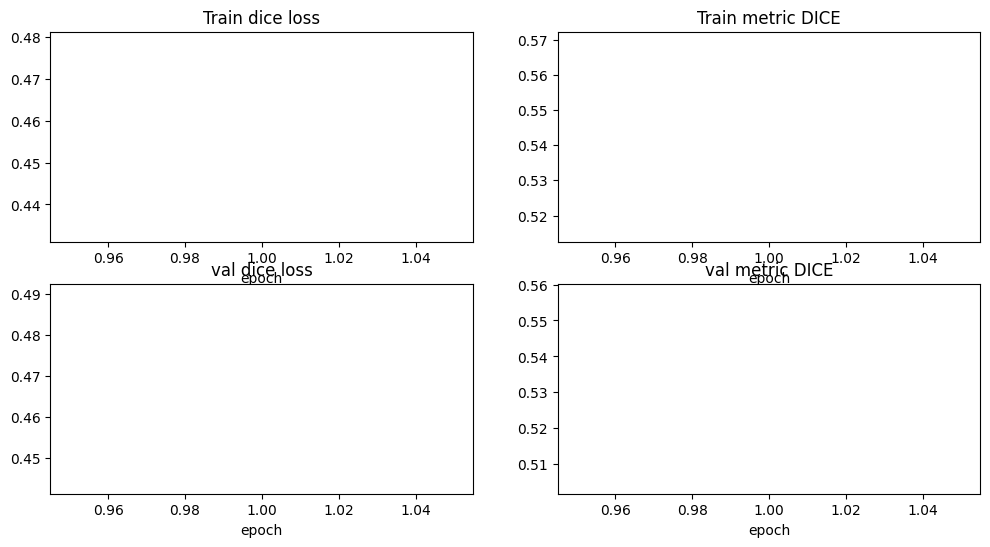

In [23]:
plt.figure("Results", (12, 6))
plt.subplot(2, 2, 1)
plt.title("Train dice loss")
x = [i + 1 for i in range(len(train_loss))]
y = train_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 2)
plt.title("Train metric DICE")
x = [i + 1 for i in range(len(train_metric))]
y = train_metric
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 3)
plt.title("val dice loss")
x = [i + 1 for i in range(len(val_loss))]
y = val_loss
plt.xlabel("epoch")
plt.plot(x, y)

plt.subplot(2, 2, 4)
plt.title("val metric DICE")
x = [i + 1 for i in range(len(val_metric))]
y = val_metric
plt.xlabel("epoch")
plt.plot(x, y)
plt.savefig(f"{path}/trian val loss.png")
plt.show()

In [27]:
path_test_volumes = sorted(glob(os.path.join(data_dir, "TestVol", "*.nii.gz")))
path_test_segmentation = sorted(glob(os.path.join(data_dir, "TestSeg", "*.nii.gz")))

test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]

In [28]:
test_transforms = Compose(
        [
            LoadImaged(keys=["vol", "seg"]),
            AddChanneld(keys=["vol", "seg"]),
            Spacingd(keys=["vol", "seg"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
            Orientationd(keys=["vol", "seg"], axcodes="RAS"),
            ScaleIntensityRanged(keys=["vol"], a_min=0, a_max=300, clip=False),
            Resized(keys=["vol", "seg"], spatial_size=[256,256,64]),
            ToTensord(keys=["vol", "seg"]),
        ]
    )
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

model.load_state_dict(torch.load(
    os.path.join(model_dir, "best_metric_model.pth")))
model.eval()

UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


In [13]:
import os
import numpy as np
import nibabel as nib
from monai.transforms import (
    Compose,
    AddChanneld,
    LoadImaged,
    Resized,
    ToTensord,
    Spacingd,
    Orientationd,
    ScaleIntensityRanged,
    CropForegroundd,
    Activations,
)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.data import CacheDataset, DataLoader, Dataset
from monai.inferers import sliding_window_inference
from monai.utils import first, set_determinism
import torch
import csv
from pathlib import Path
from glob import glob

# Define data directories
data_dir = 'D:/grad/Landmarks-images'
model_dir = Path("D:/grad/Landmarks-images/Landmark seg all points model")

# Define test paths
path_test_volumes = sorted(glob(os.path.join(data_dir, "TestVol", "*.nii.gz")))
path_test_segmentation = sorted(glob(os.path.join(data_dir, "TestSeg", "*.nii.gz")))

# Define transforms for test data
test_transforms = Compose([
    LoadImaged(keys=["vol", "seg"]),
    AddChanneld(keys=["vol", "seg"]),
    Spacingd(keys=["vol", "seg"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
    Orientationd(keys=["vol", "seg"], axcodes="RAS"),
    ScaleIntensityRanged(keys=["vol"], a_min=0, a_max=300, clip=False),
    Resized(keys=["vol", "seg"], spatial_size=[256, 256, 64]),
    ToTensord(keys=["vol", "seg"]),
])

# Create test dataset and dataloader
test_files = [{"vol": image_name, "seg": label_name} for image_name, label_name in zip(path_test_volumes, path_test_segmentation)]
test_ds = Dataset(data=test_files, transform=test_transforms)
test_loader = DataLoader(test_ds, batch_size=1)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load model
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH,
).to(device)

model.load_state_dict(torch.load(os.path.join(model_dir, "best_metric_model.pth")))
model.eval()

# # Inference parameters
# sw_batch_size = 4
# roi_size = (256, 256, 64)

# # Output directory for enhanced segmentations and CSV files
# output_dir = os.path.join(data_dir, "Test output")
# csv_output_dir = os.path.join(data_dir, "SegmentationCSVs")
# os.makedirs(output_dir, exist_ok=True)
# os.makedirs(csv_output_dir, exist_ok=True)

# # Function to save ones locations to CSV
# def save_ones_locations(nifti_path, csv_output_path):
#     nifti_img = nib.load(nifti_path)
#     nifti_data = nifti_img.get_fdata()
#     ones_indices = np.argwhere(nifti_data == 1)
#     with open(csv_output_path, mode='w', newline='') as file:
#         writer = csv.writer(file)
#         writer.writerow(["x", "y", "z"])
#         writer.writerows(ones_indices)
#     print(f"Locations of ones saved to {csv_output_path}")

# # Perform inference and save results
# with torch.no_grad():
#     for idx, test_patient in enumerate(test_loader):
#         t_volume = test_patient['vol']
#         seg_filename = os.path.basename(test_files[idx]["seg"])
#         output_path = os.path.join(output_dir, seg_filename)
#         csv_output_path = os.path.join(csv_output_dir, seg_filename.replace('.nii.gz', '.csv'))

#         test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
#         sigmoid_activation = Activations(sigmoid=True)
#         test_outputs = sigmoid_activation(test_outputs)
#         test_outputs = test_outputs > 0.1

#         # Save the enhanced segmentation
#         test_outputs_np = test_outputs.cpu().numpy().astype(np.uint8)
#         original_nii = nib.load(test_files[idx]["seg"])
#         print(original_nii.affine)
#         enhanced_seg_nii = nib.Nifti1Image(test_outputs_np[0, 1], original_nii.affine, original_nii.header)
#         # nib.save(enhanced_seg_nii, output_path)
#         # print(f"Saved enhanced segmentation to {output_path}")

#         # # Save the locations of ones to CSV
#         # save_ones_locations(output_path, csv_output_path)


UNet(
  (model): Sequential(
    (0): ResidualUnit(
      (conv): Sequential(
        (unit0): Convolution(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
        (unit1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
          (adn): ADN(
            (N): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (D): Dropout(p=0.0, inplace=False)
            (A): PReLU(num_parameters=1)
          )
        )
      )
      (residual): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    )
    (1): SkipConnection(
      (submodule): Sequential(
        (0): ResidualUnit(
          (conv): Sequential(


c:\Users\Nouran Hady Shaaban\anaconda3\envs\new_env\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Annulus plane radius: 7.536504639883746
LCA-RCA plane radius: 16.658331248957683
STJ plane radius: 4.503403617533656


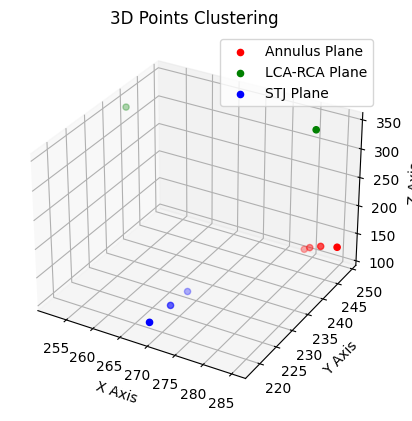

In [15]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define the points
points = np.array([
    [281, 248, 332],
    [252, 238, 345],
    [270, 241, 148],
    [221, 226, 150],
    [279, 249, 109],
    [280, 249, 115],
    [282, 249, 123],
    [285, 249, 130],
    [269, 218, 118],
    [269, 224, 114],
    [269, 229, 111]
])

# Use K-means clustering to classify points into more than 3 clusters
initial_clusters = 5
kmeans = KMeans(n_clusters=initial_clusters)
kmeans.fit(points)
labels = kmeans.labels_

# Ensure each plane has at least 2 points
clusters = [points[labels == i] for i in range(initial_clusters)]
valid_clusters = [cluster for cluster in clusters if len(cluster) >= 2]

# Merge clusters if necessary
while len(valid_clusters) < 3:
    smallest_cluster = min(valid_clusters, key=len)
    valid_clusters.remove(smallest_cluster)
    nearest_cluster = min(valid_clusters, key=lambda c: np.linalg.norm(c.mean(axis=0) - smallest_cluster.mean(axis=0)))
    merged_cluster = np.vstack([smallest_cluster, nearest_cluster])
    valid_clusters.remove(nearest_cluster)
    valid_clusters.append(merged_cluster)

# Assign to specific planes
annulus_points, lca_rca_points, stj_points = valid_clusters[:3]

# Function to calculate centroid
def calculate_centroid(points):
    return np.mean(points, axis=0)

# Function to calculate average radius
def calculate_radius(points, centroid):
    distances = np.linalg.norm(points - centroid, axis=1)
    return np.mean(distances)

# Calculate centroids
annulus_centroid = calculate_centroid(annulus_points)
lca_rca_centroid = calculate_centroid(lca_rca_points)
stj_centroid = calculate_centroid(stj_points)

# Calculate radii
annulus_radius = calculate_radius(annulus_points, annulus_centroid)
lca_rca_radius = calculate_radius(lca_rca_points, lca_rca_centroid)
stj_radius = calculate_radius(stj_points, stj_centroid)

print(f"Annulus plane radius: {annulus_radius}")
print(f"LCA-RCA plane radius: {lca_rca_radius}")
print(f"STJ plane radius: {stj_radius}")

# Plot the points and their clusters
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(annulus_points[:, 0], annulus_points[:, 1], annulus_points[:, 2], c='r', marker='o', label='Annulus Plane')
ax.scatter(lca_rca_points[:, 0], lca_rca_points[:, 1], lca_rca_points[:, 2], c='g', marker='o', label='LCA-RCA Plane')
ax.scatter(stj_points[:, 0], stj_points[:, 1], stj_points[:, 2], c='b', marker='o', label='STJ Plane')

# Label the axes
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# Set the title
ax.set_title('3D Points Clustering')

# Add a legend
ax.legend()

# Show the plot
plt.show()

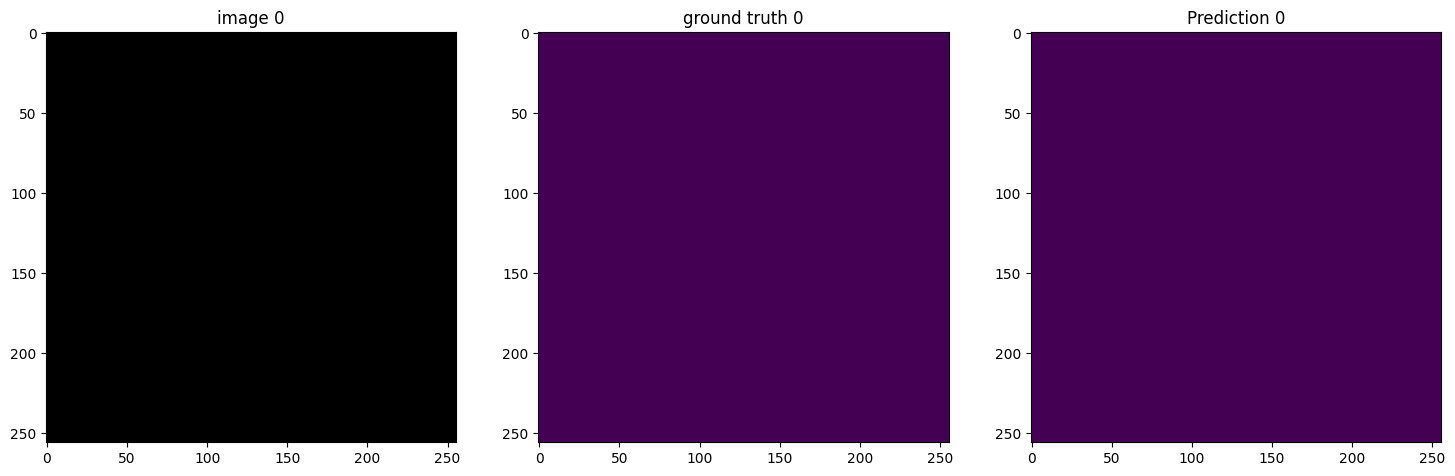

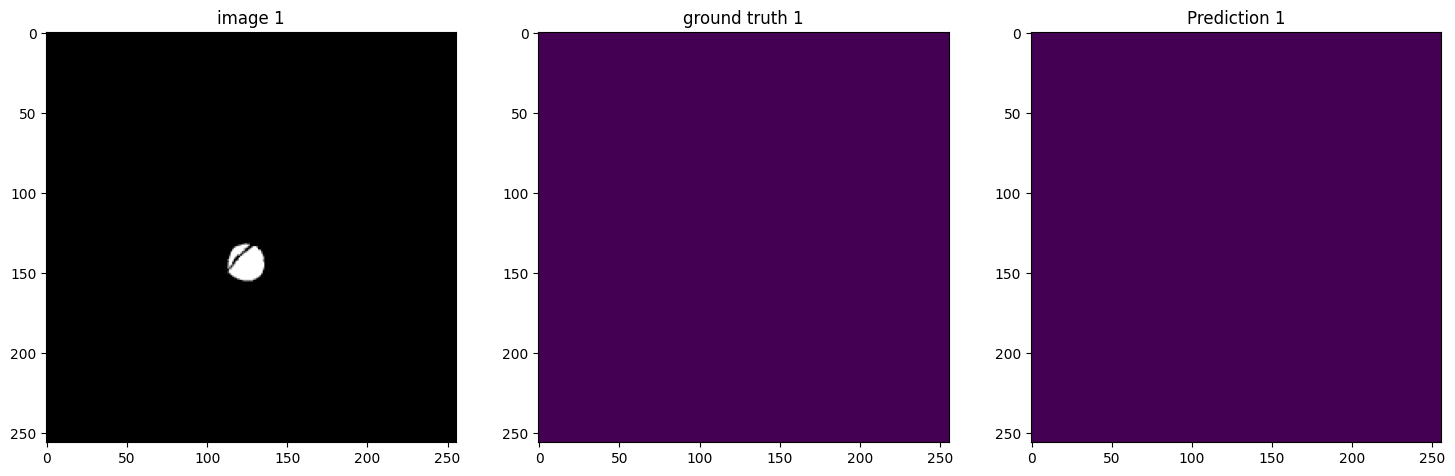

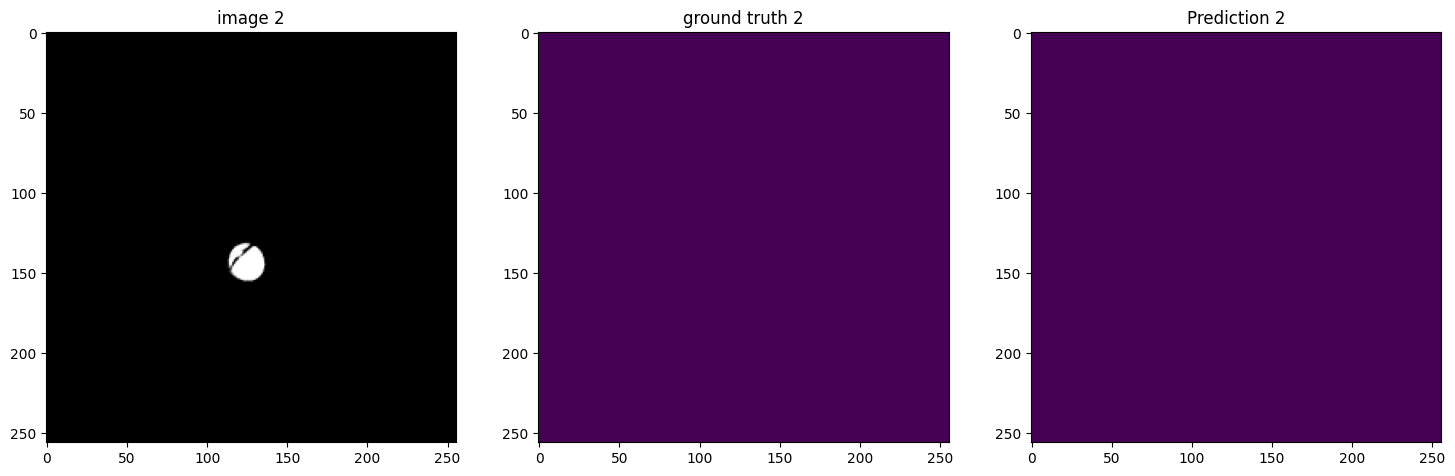

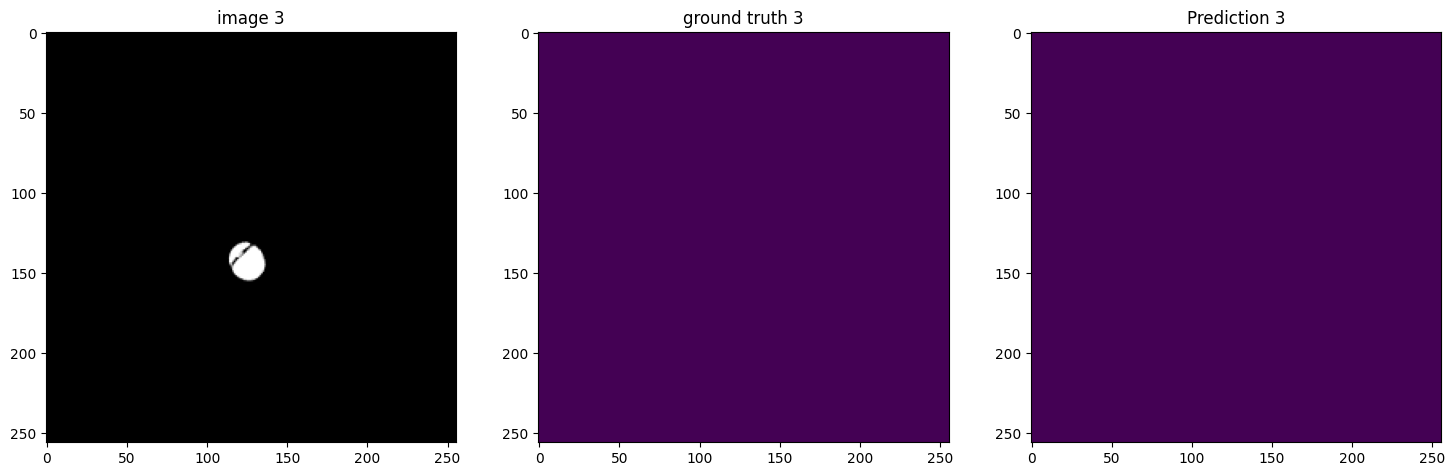

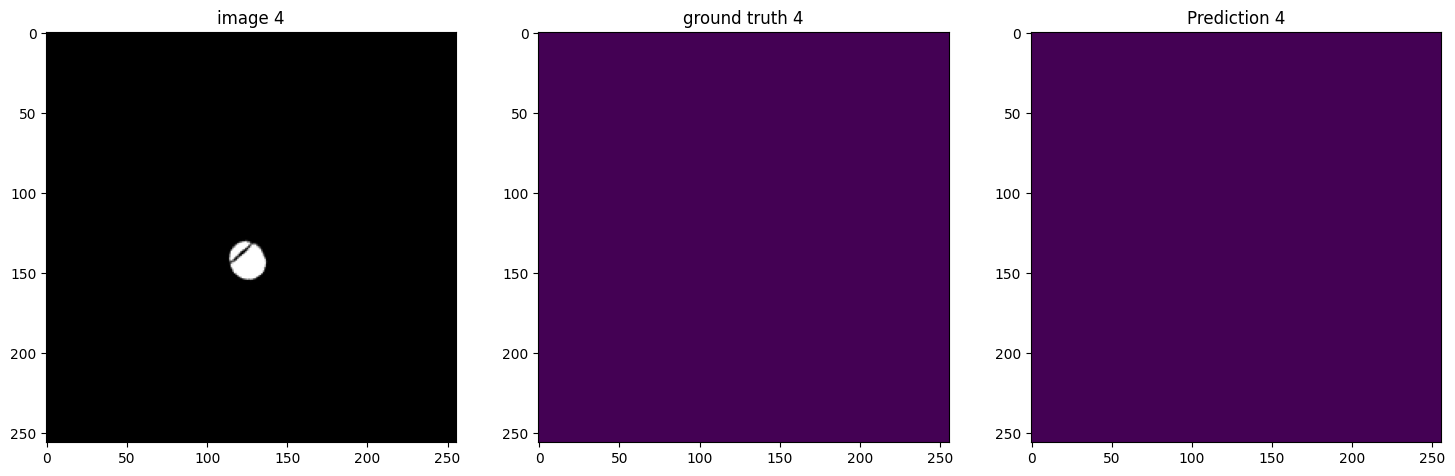

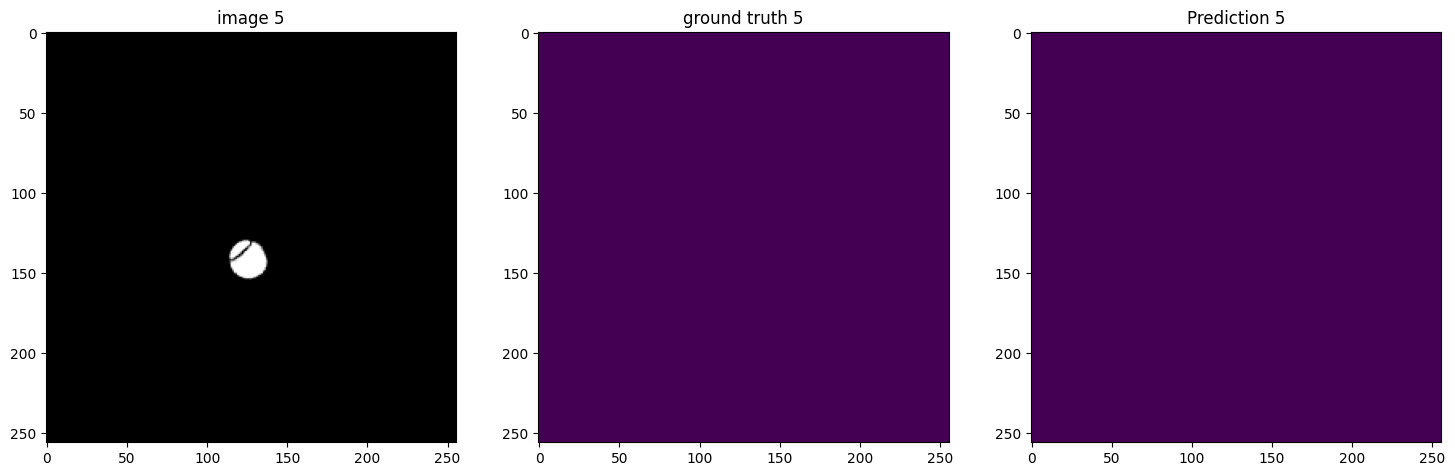

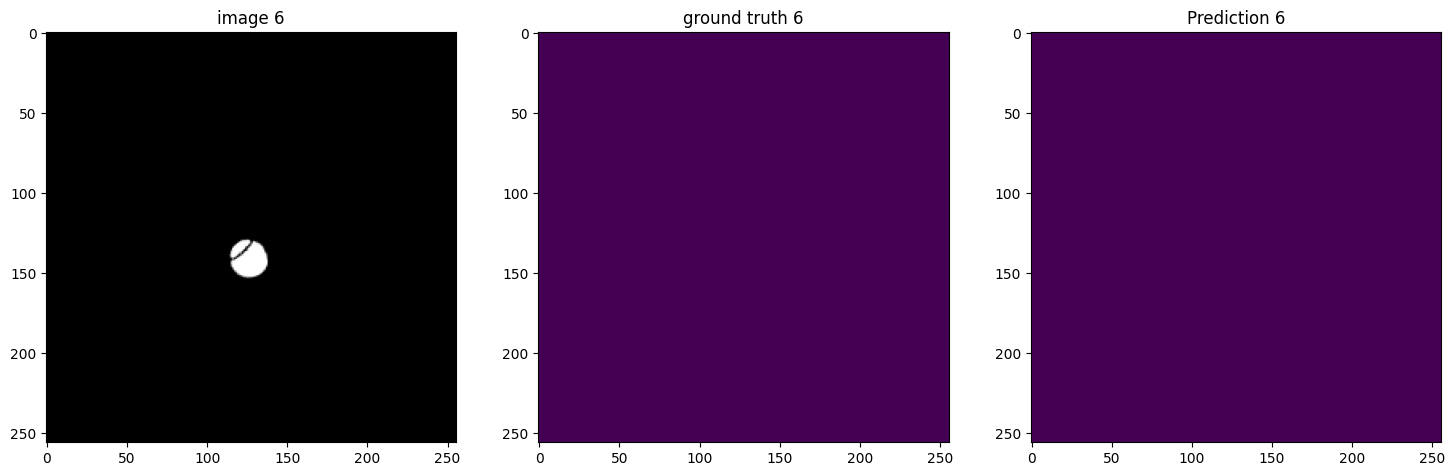

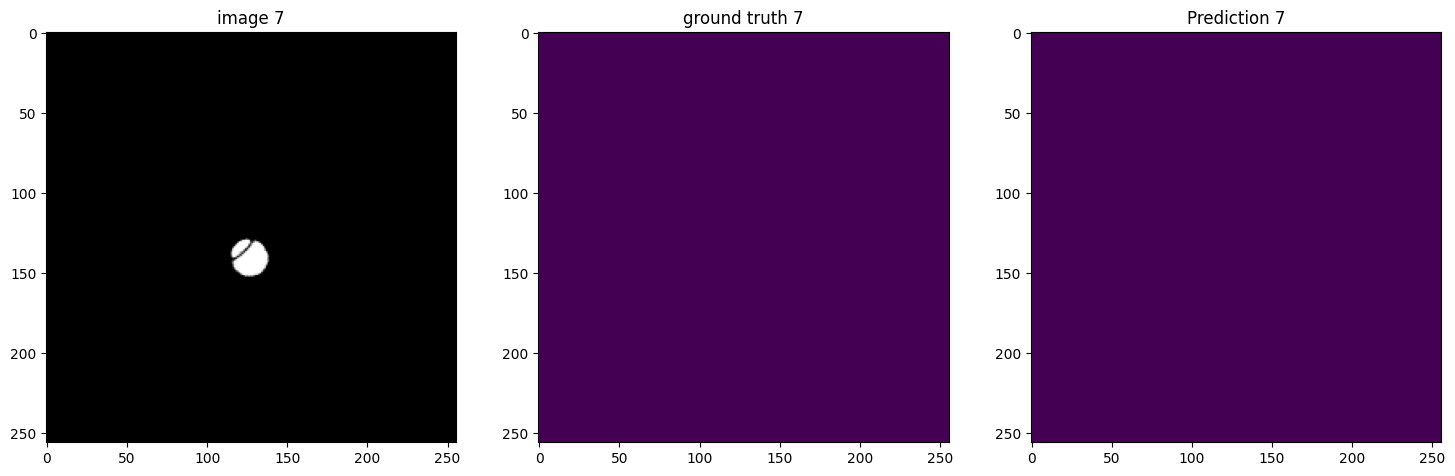

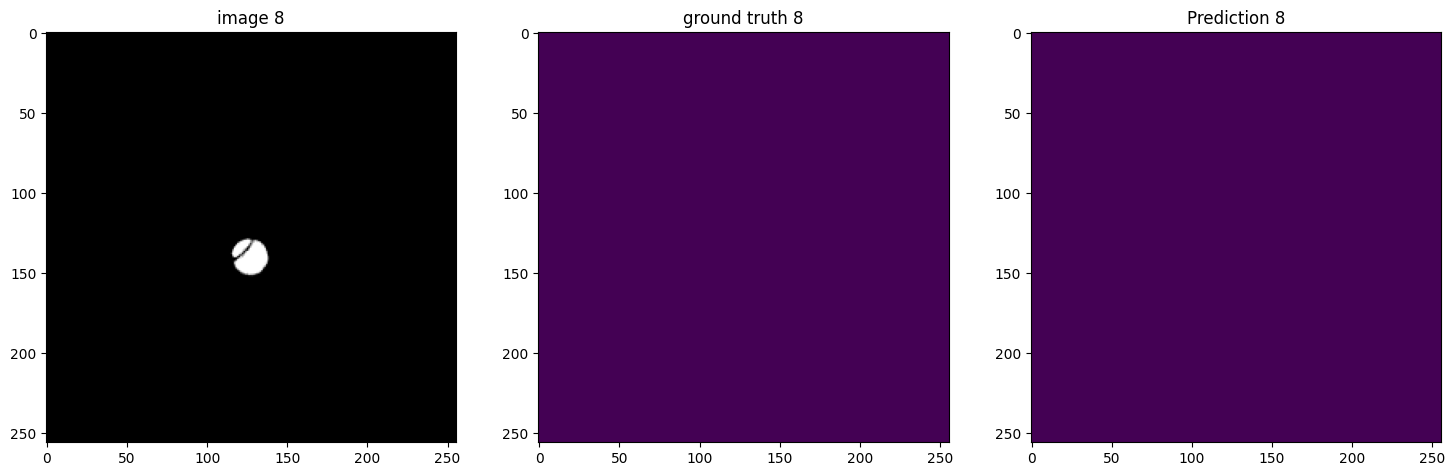

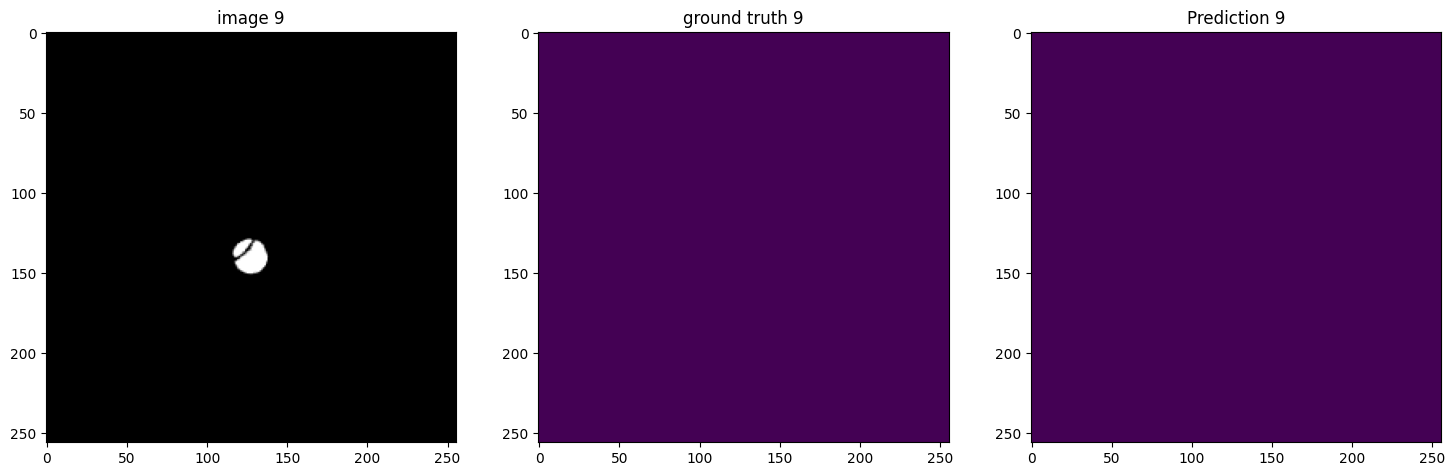

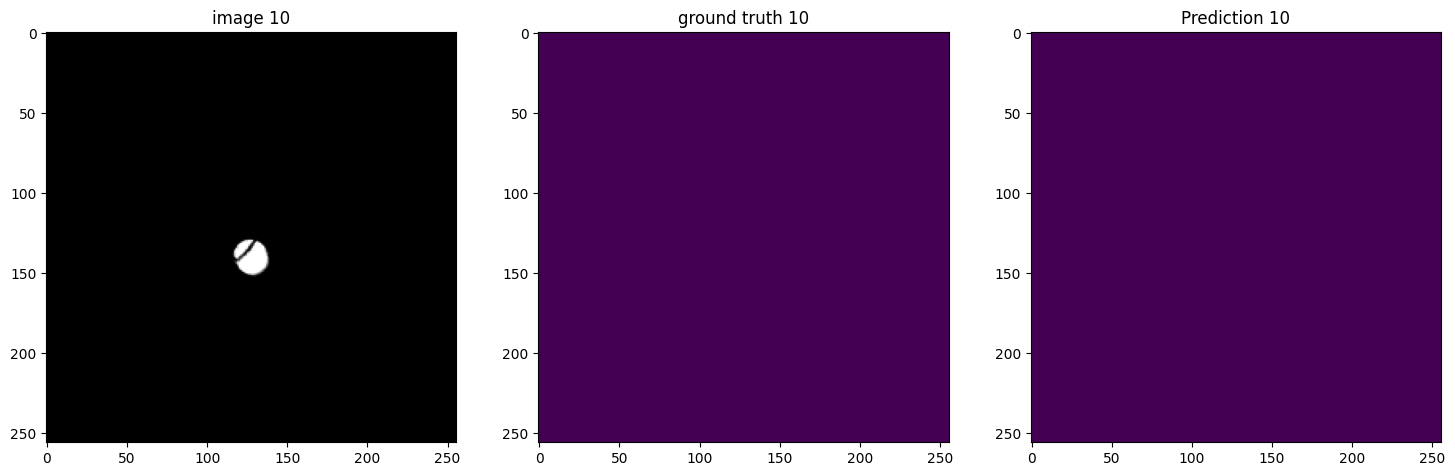

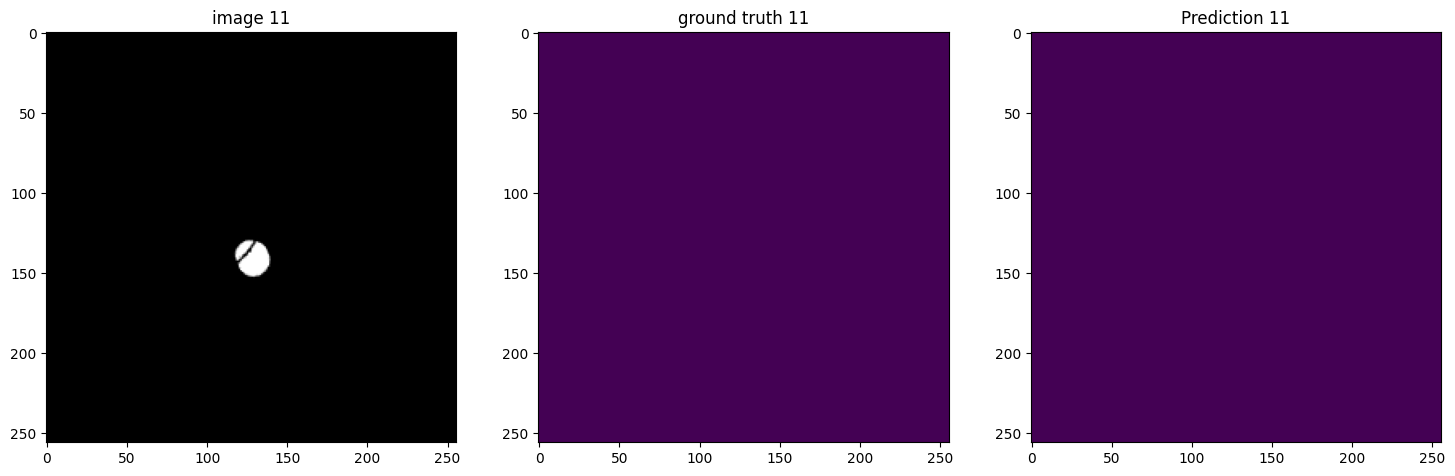

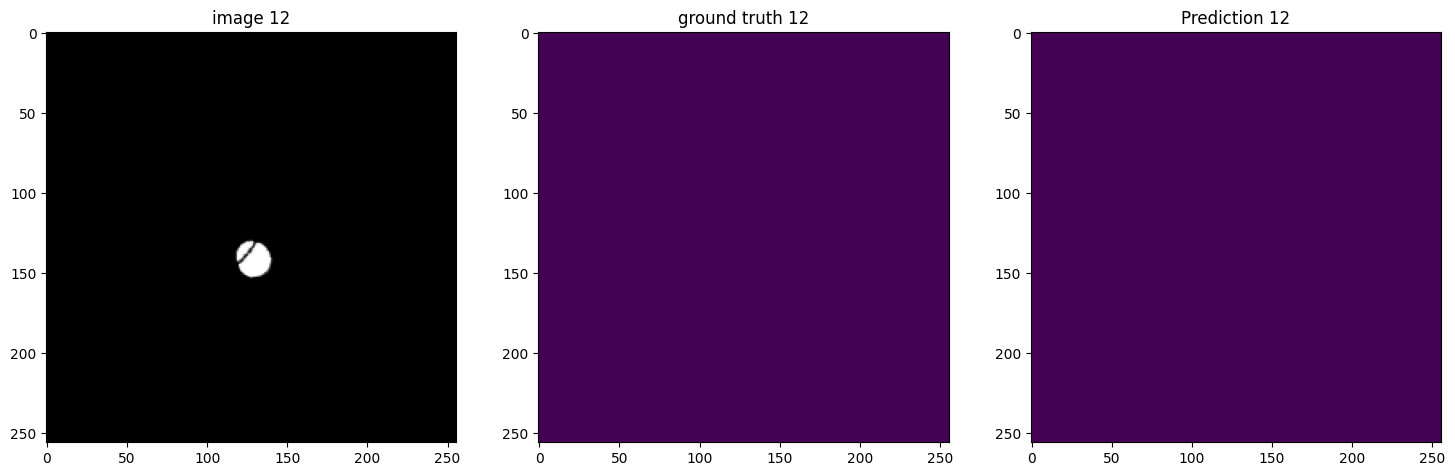

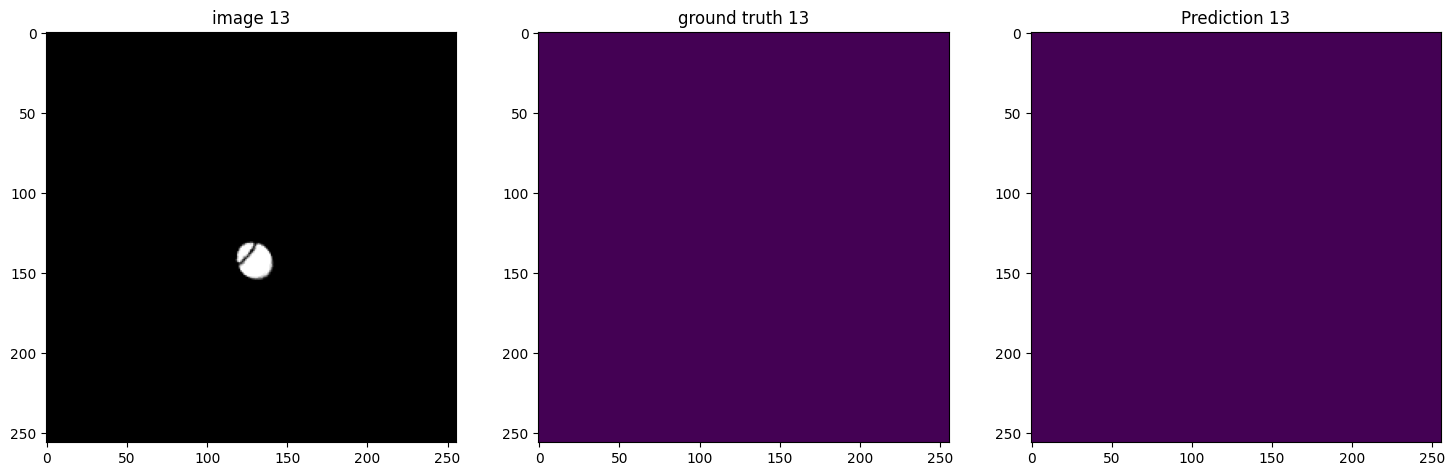

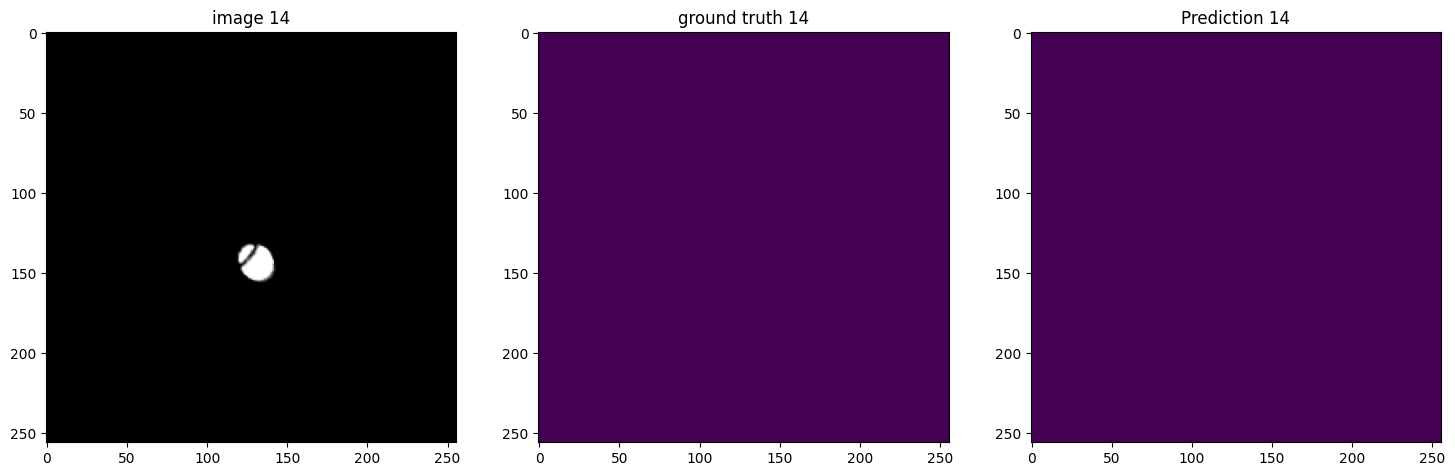

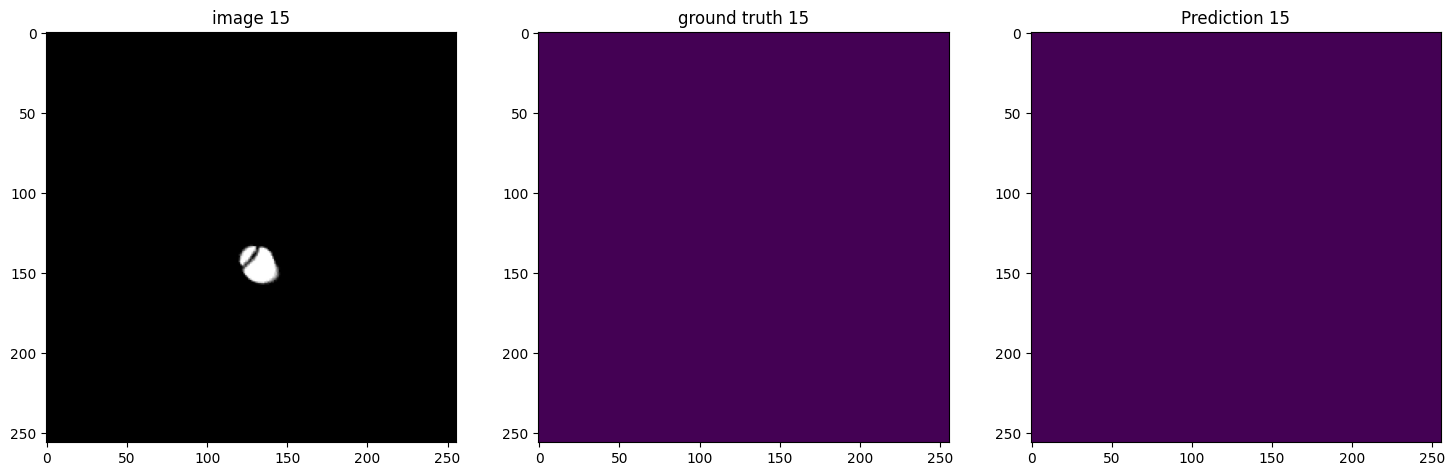

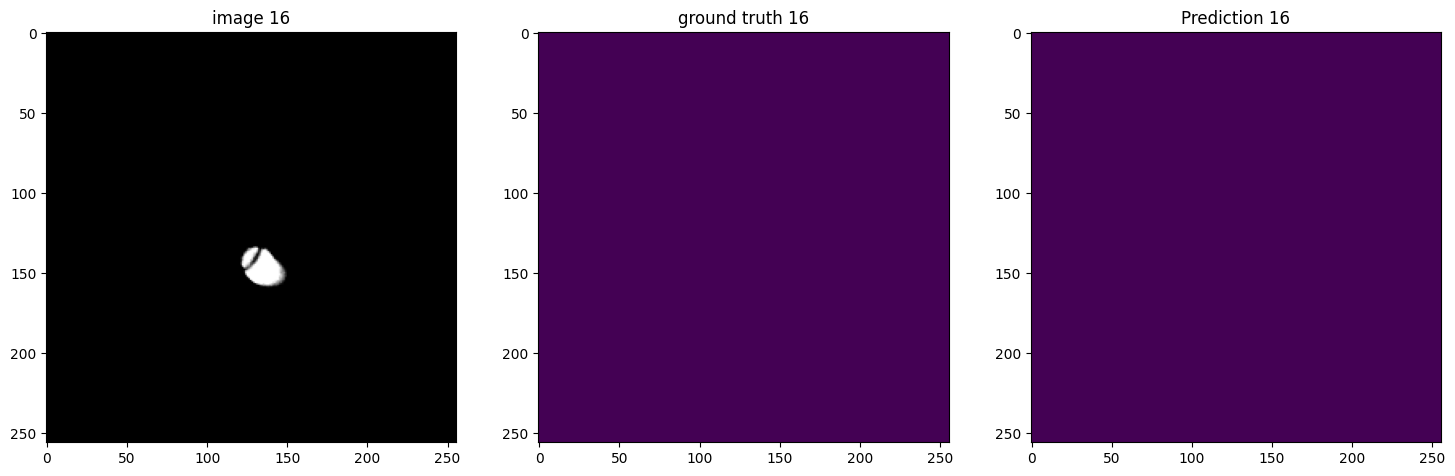

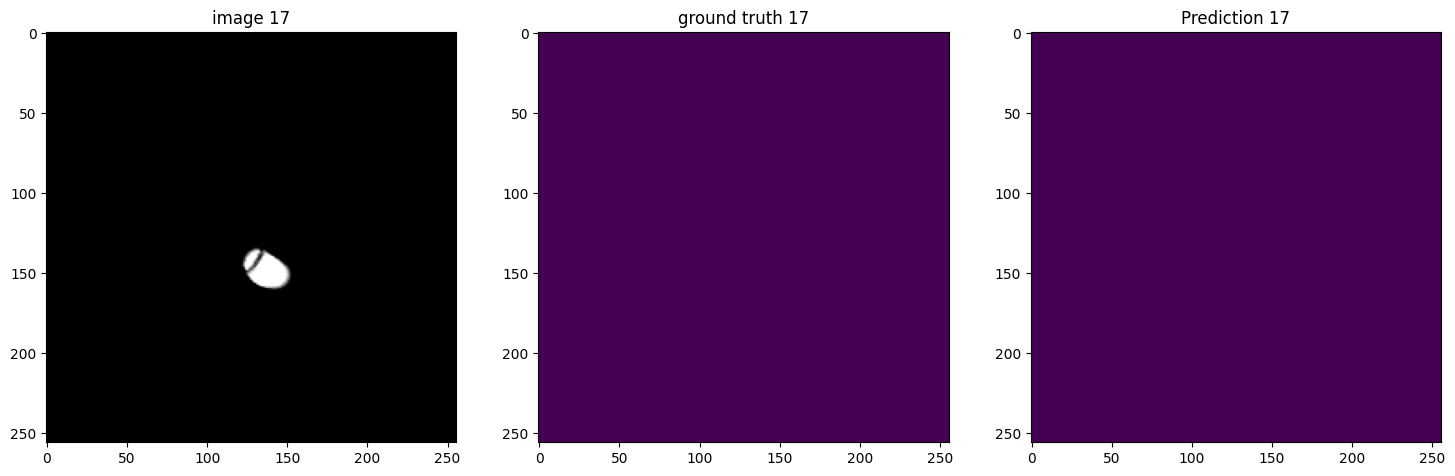

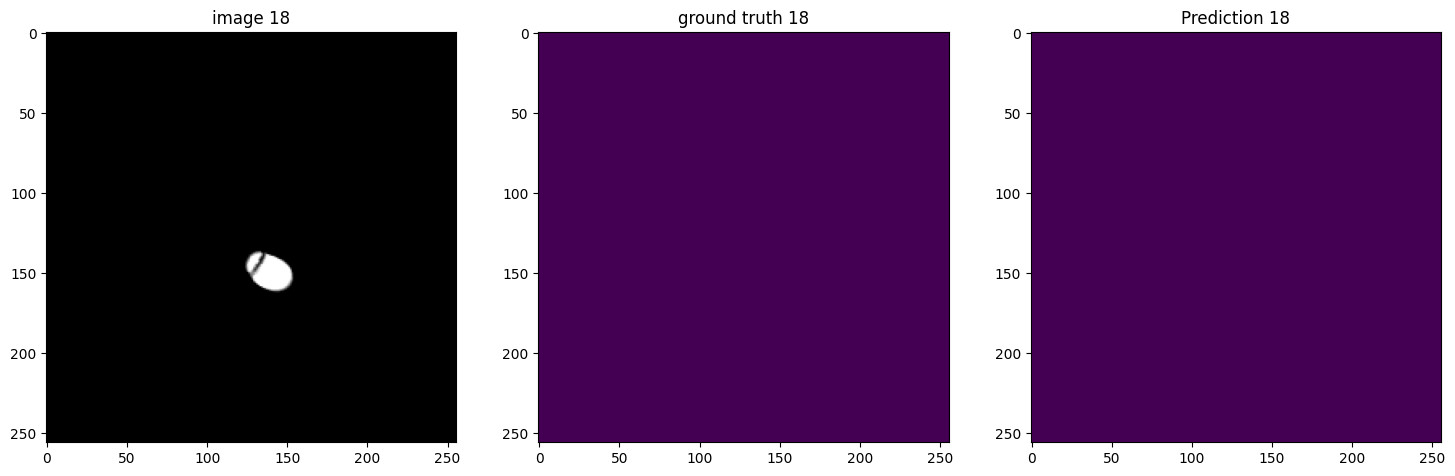

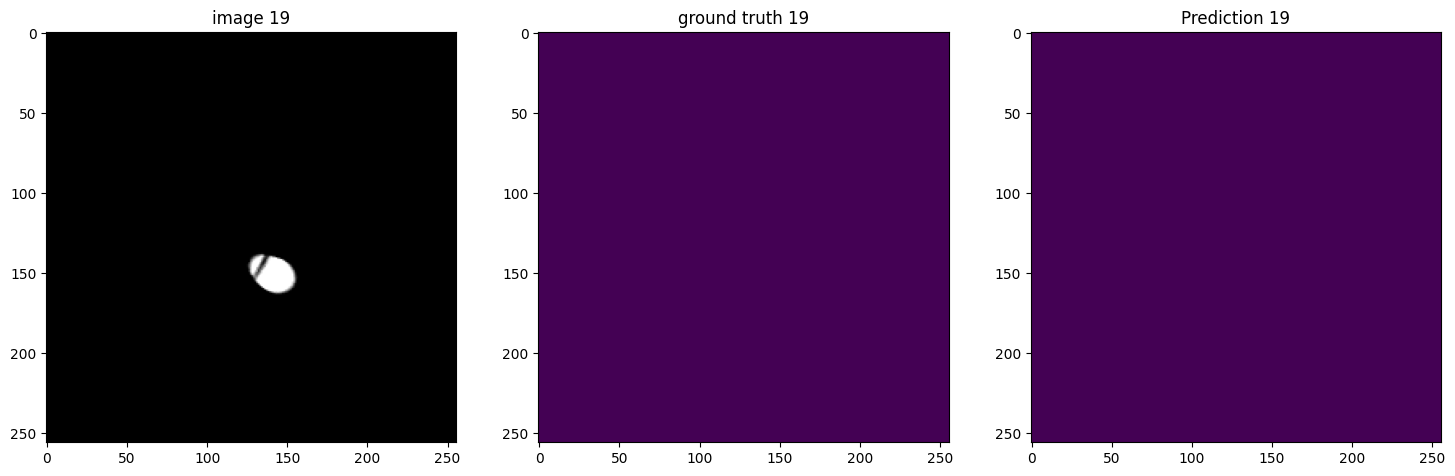

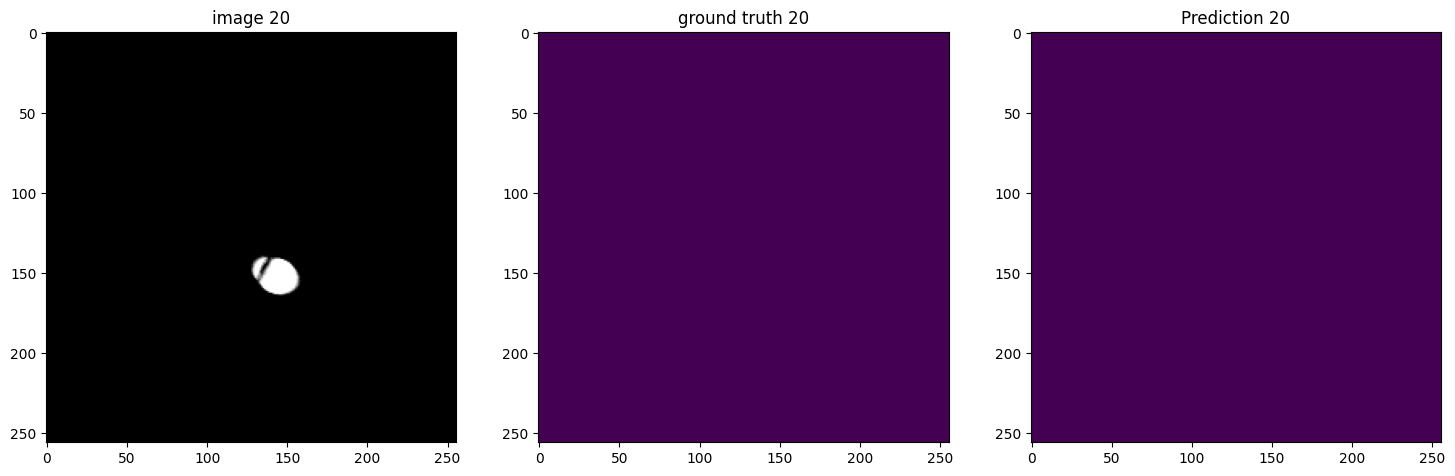

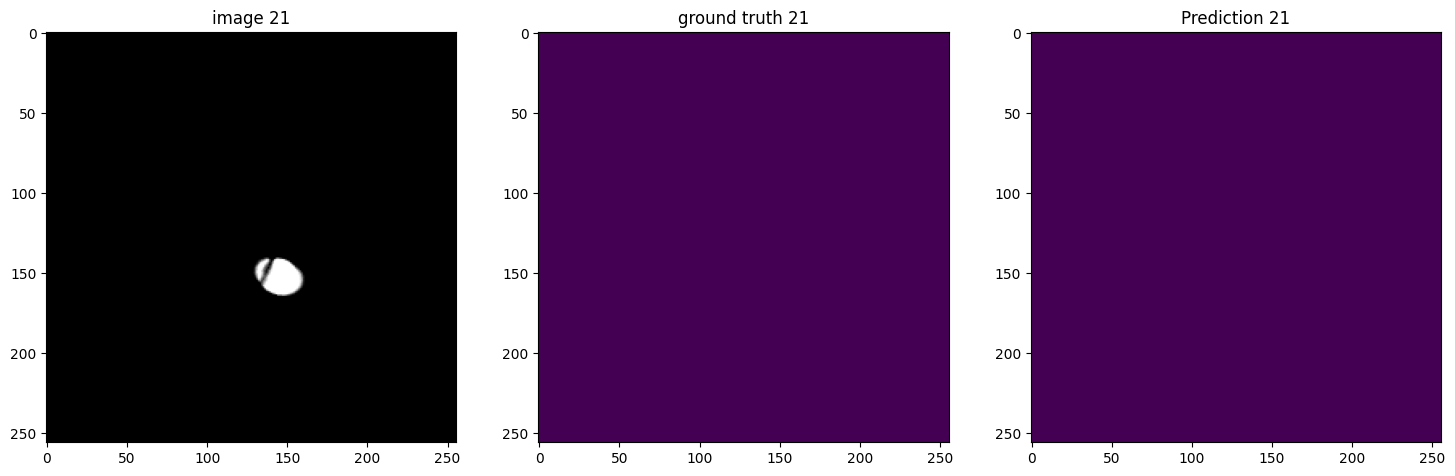

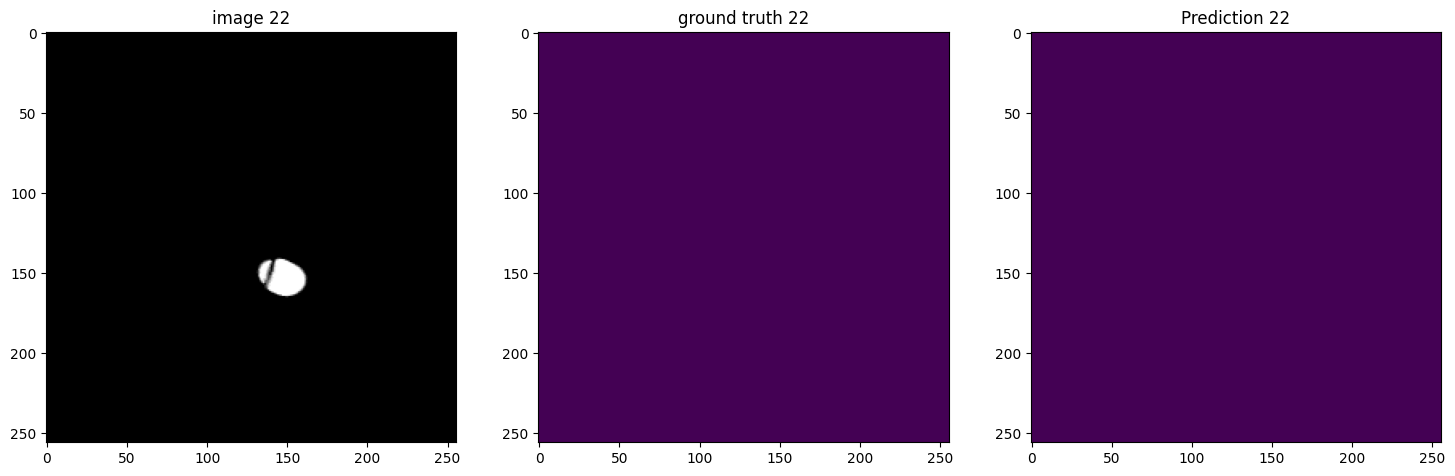

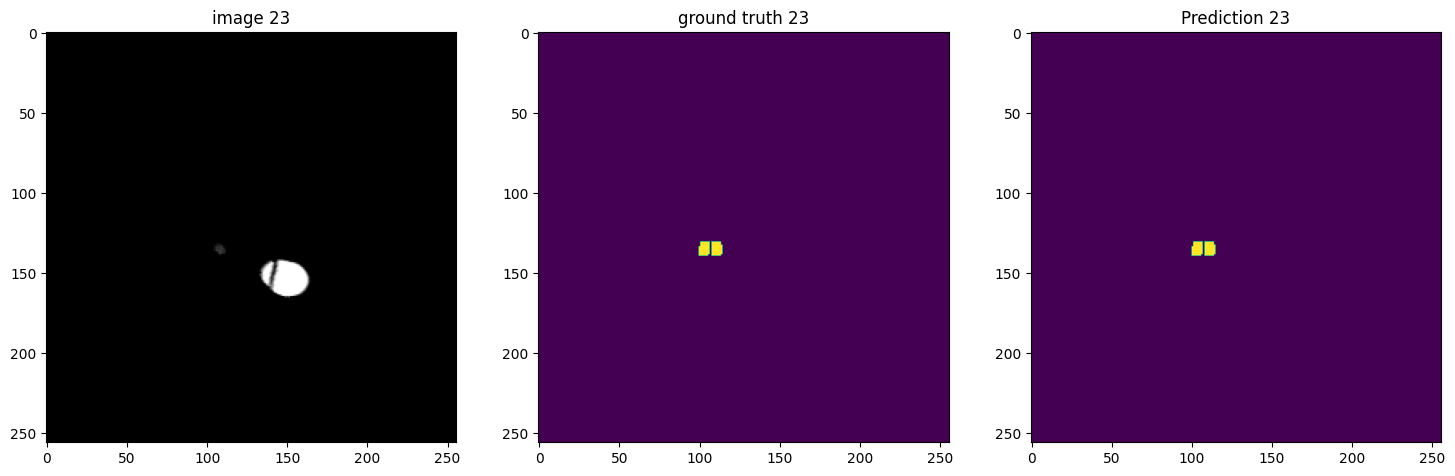

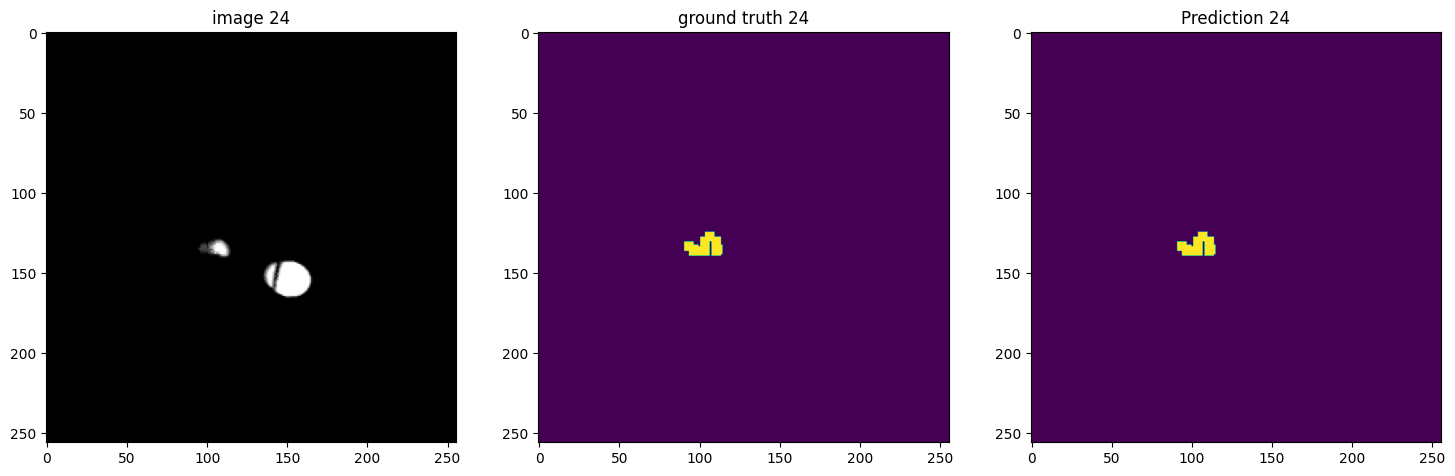

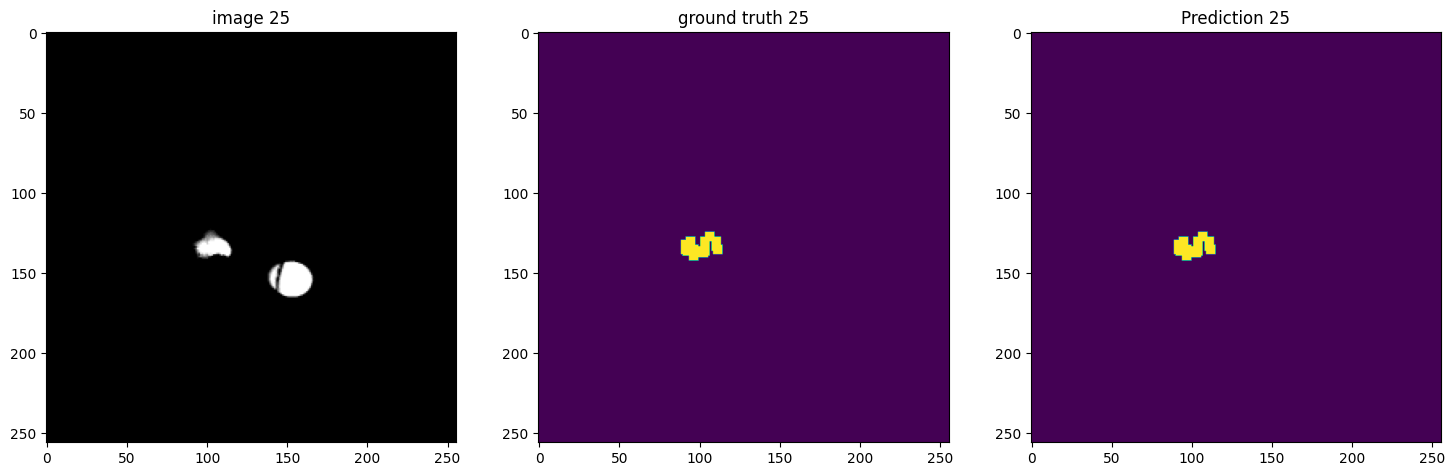

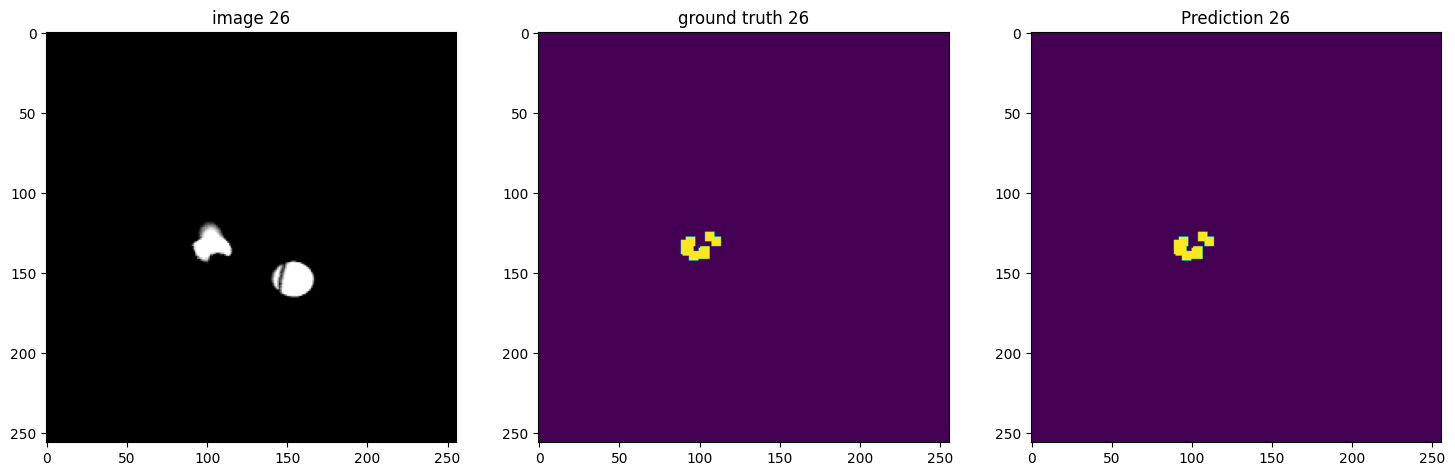

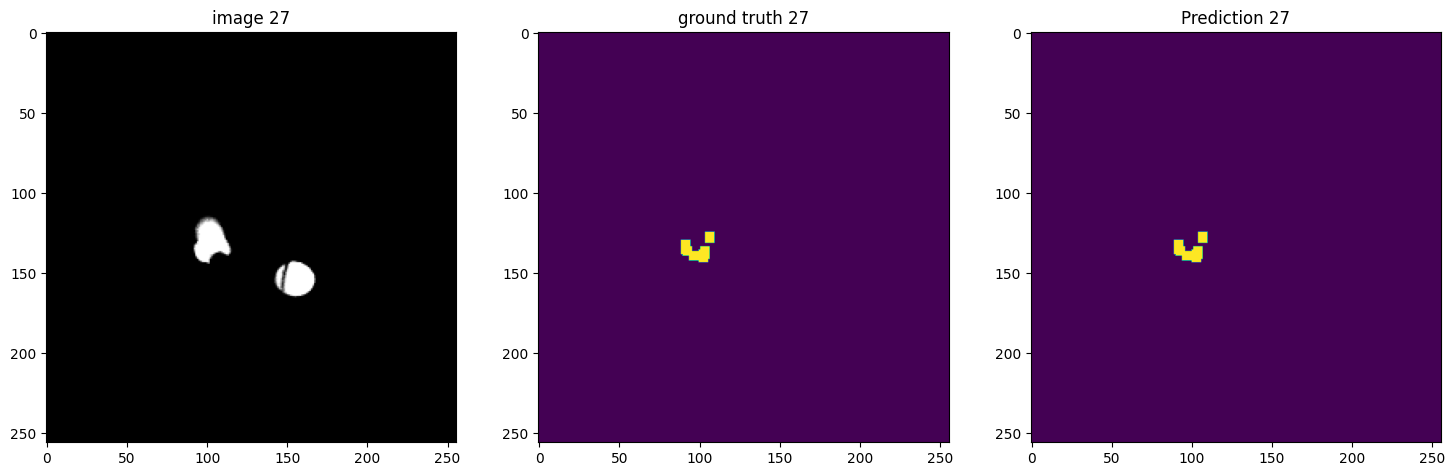

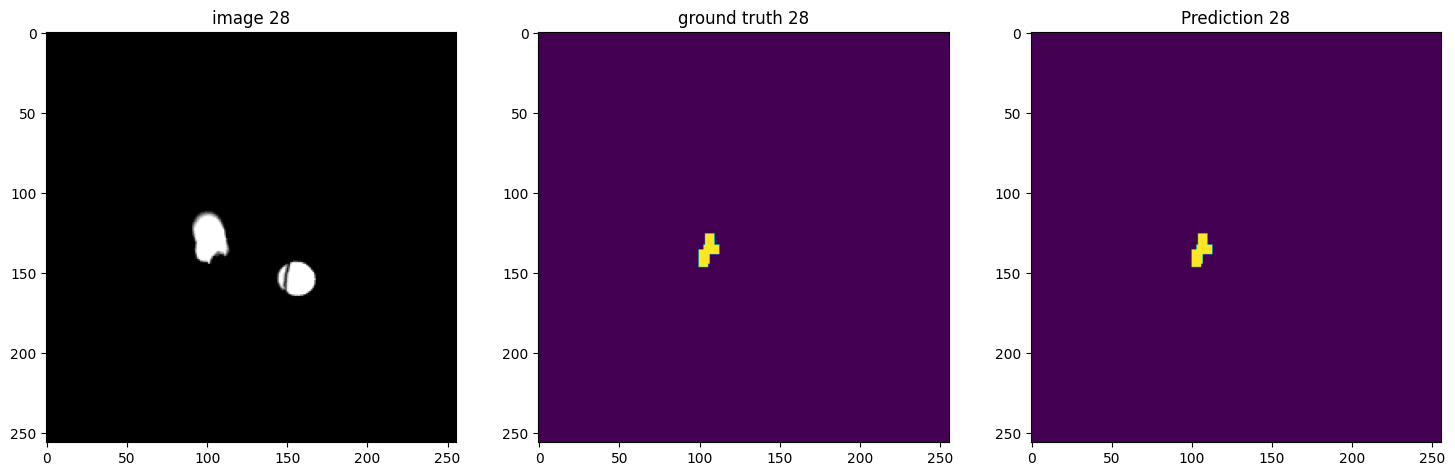

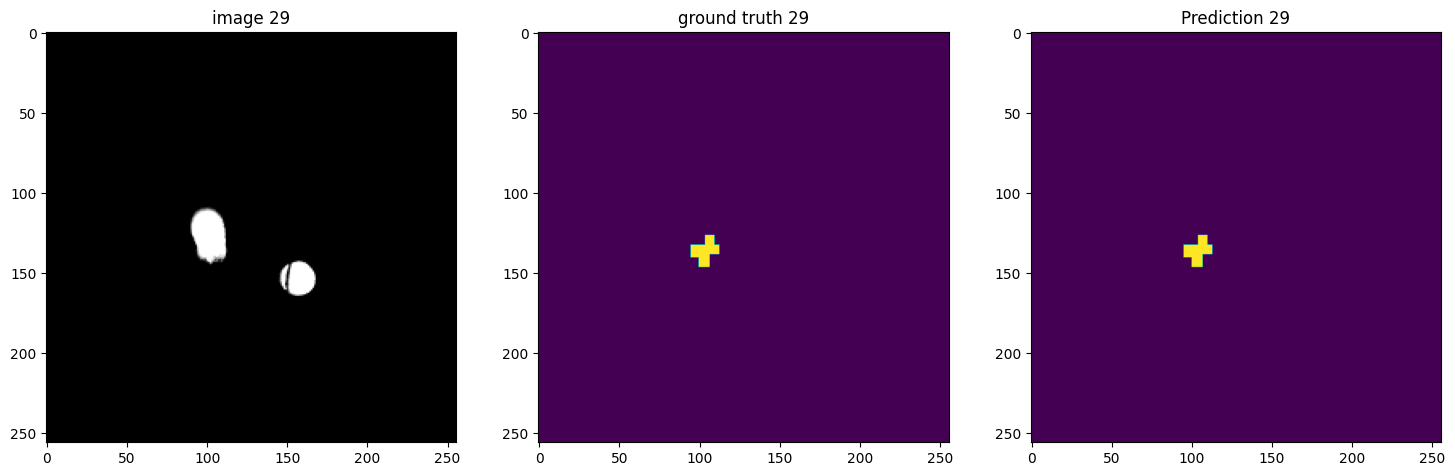

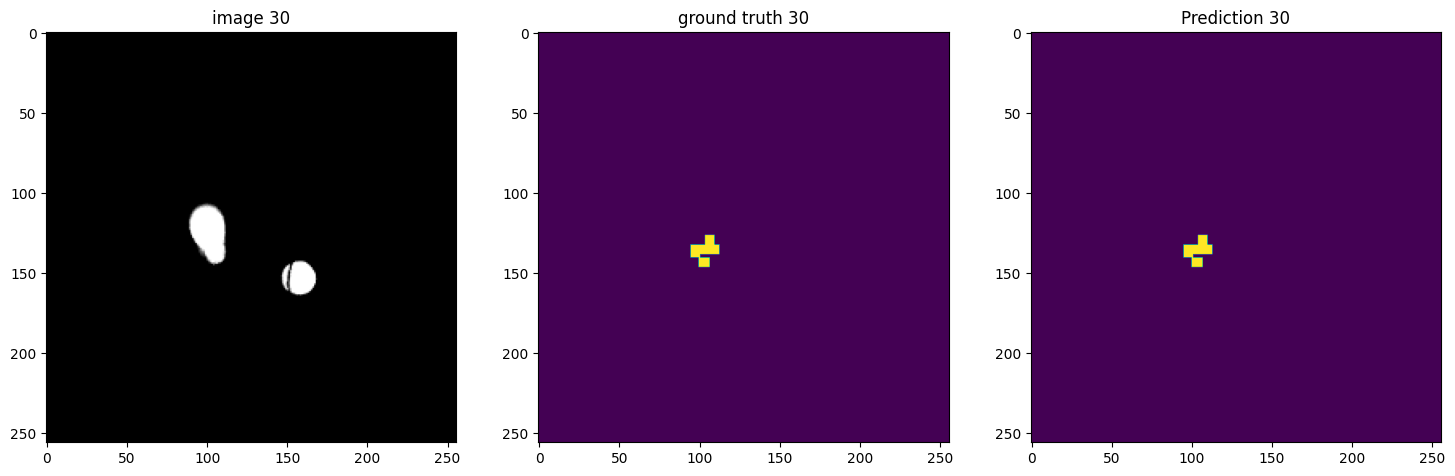

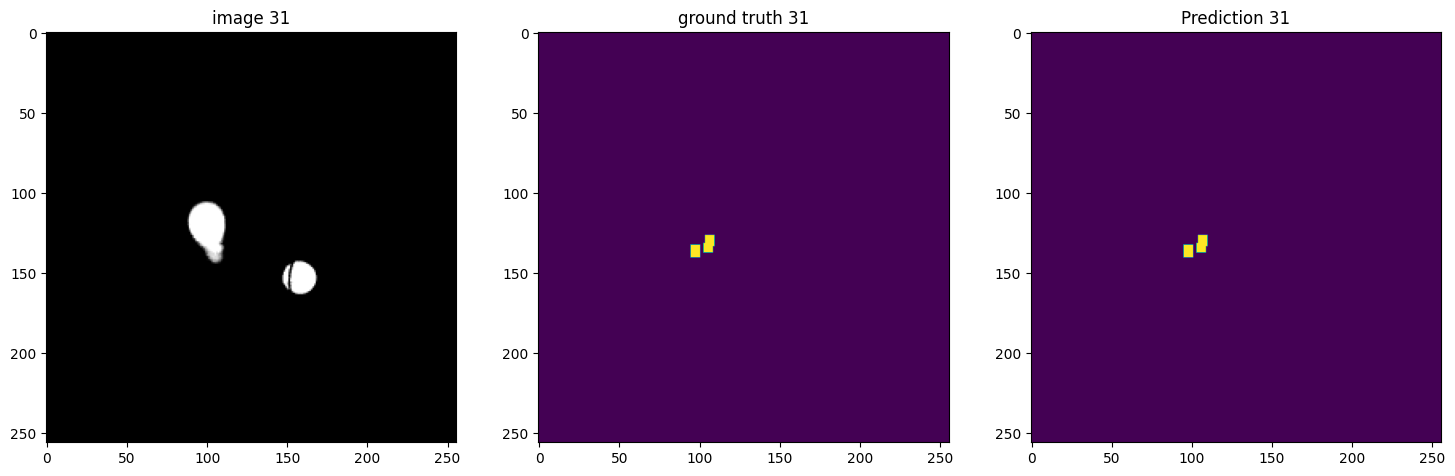

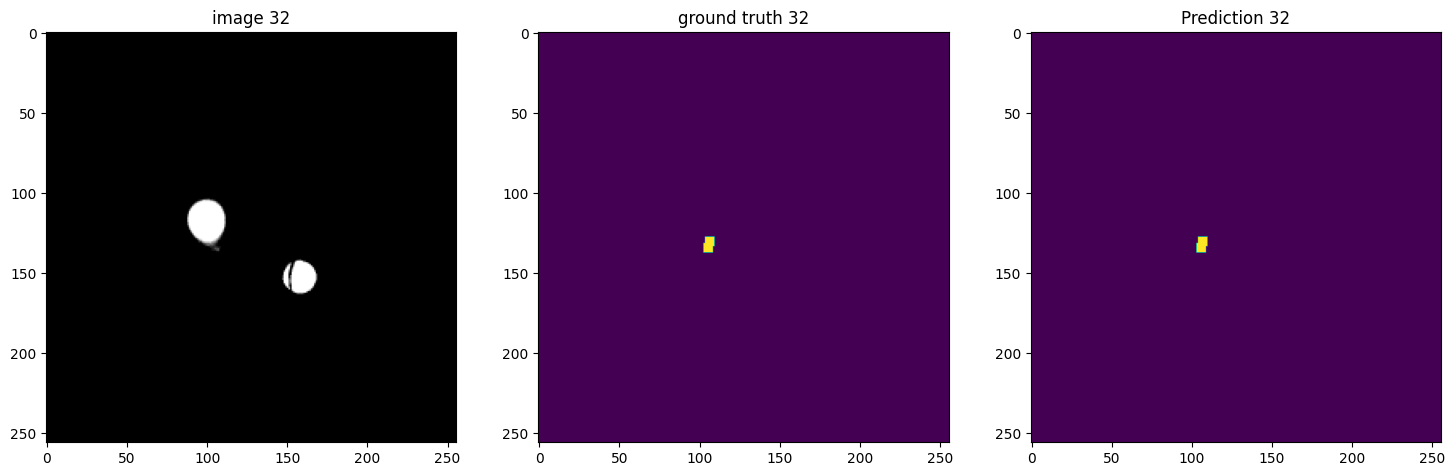

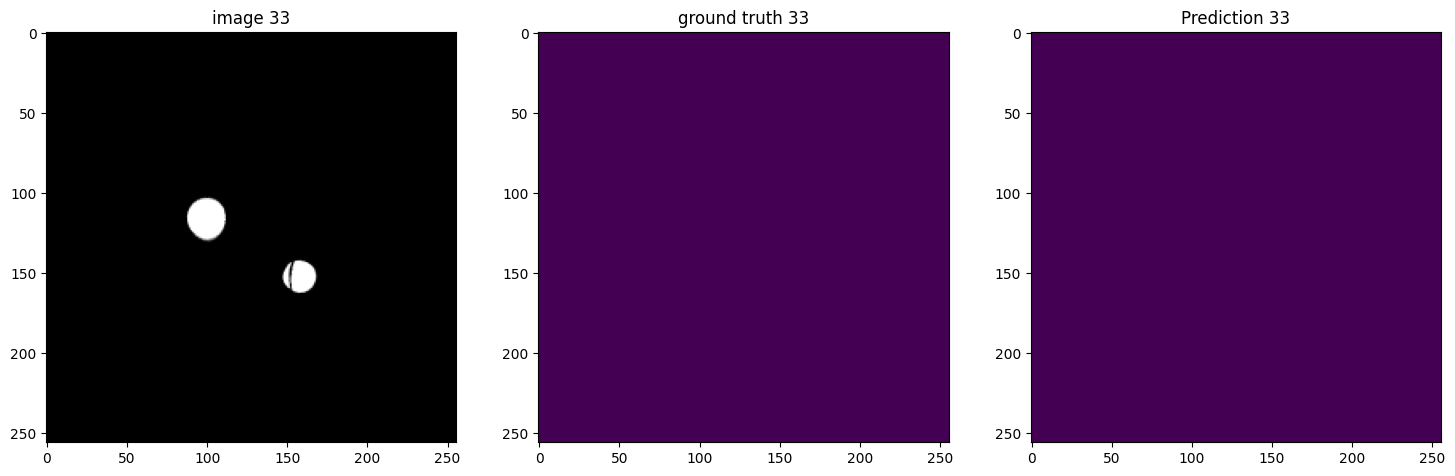

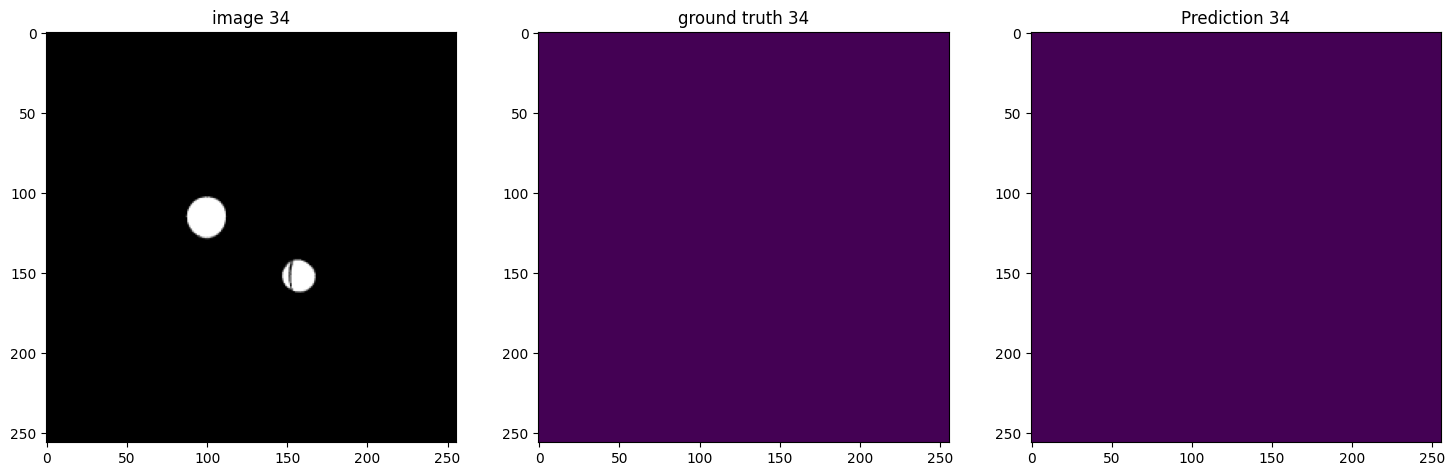

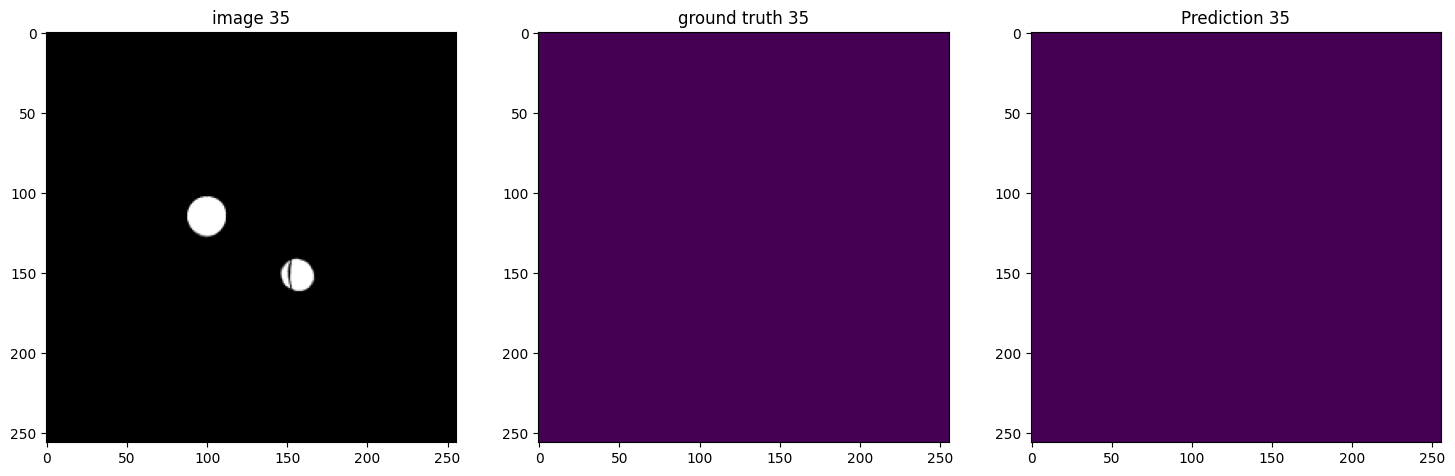

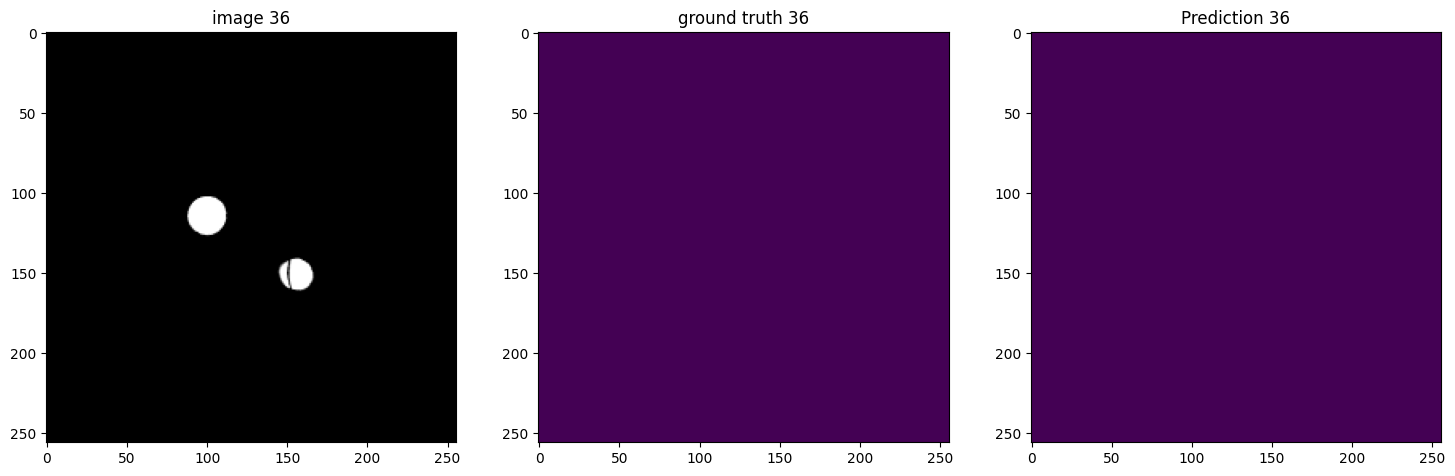

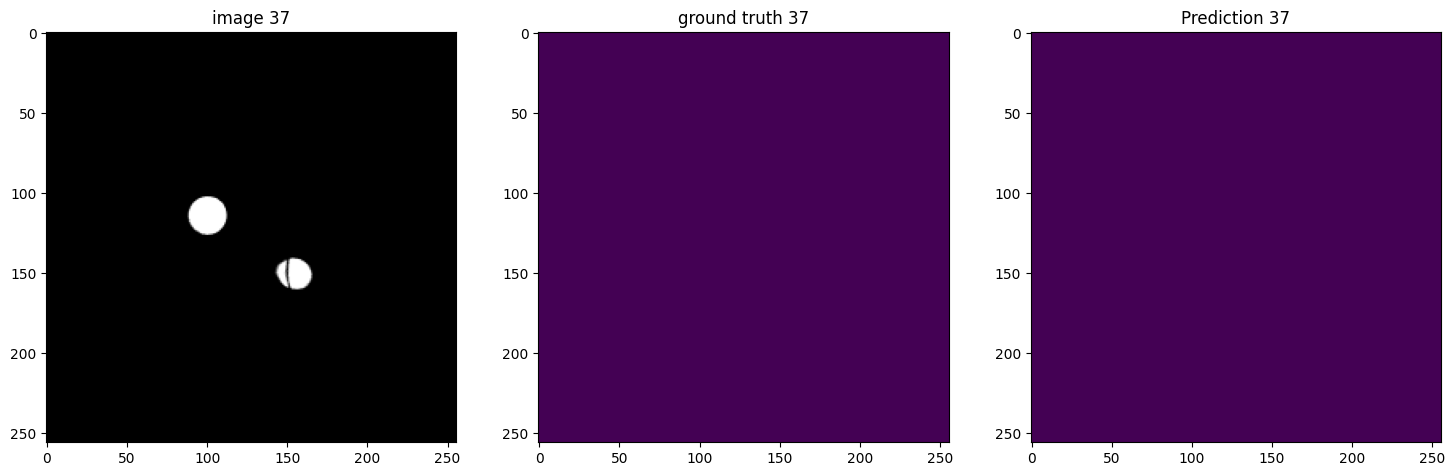

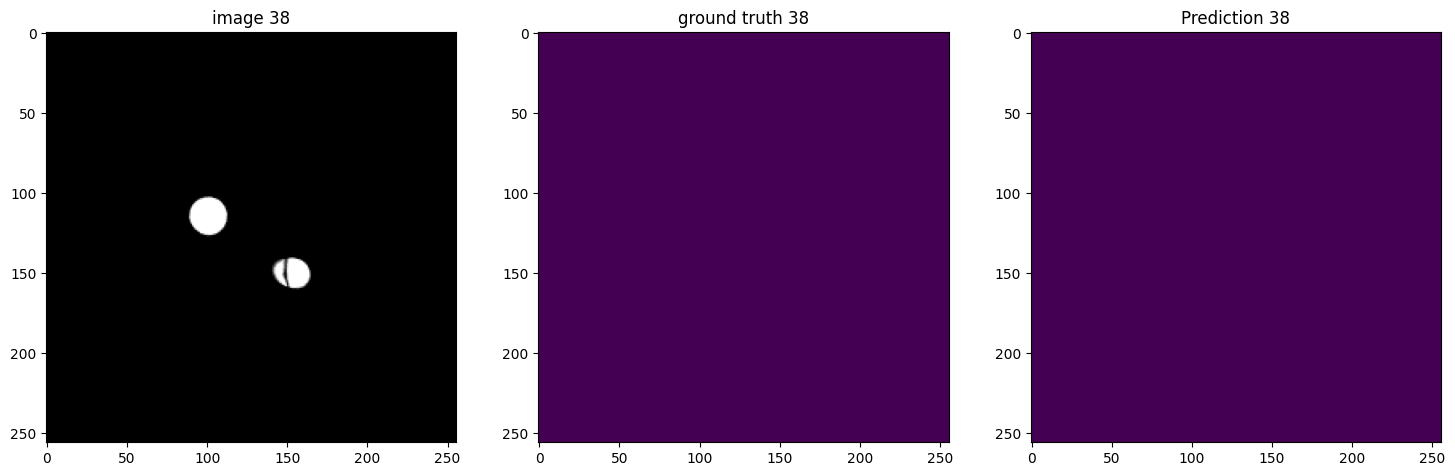

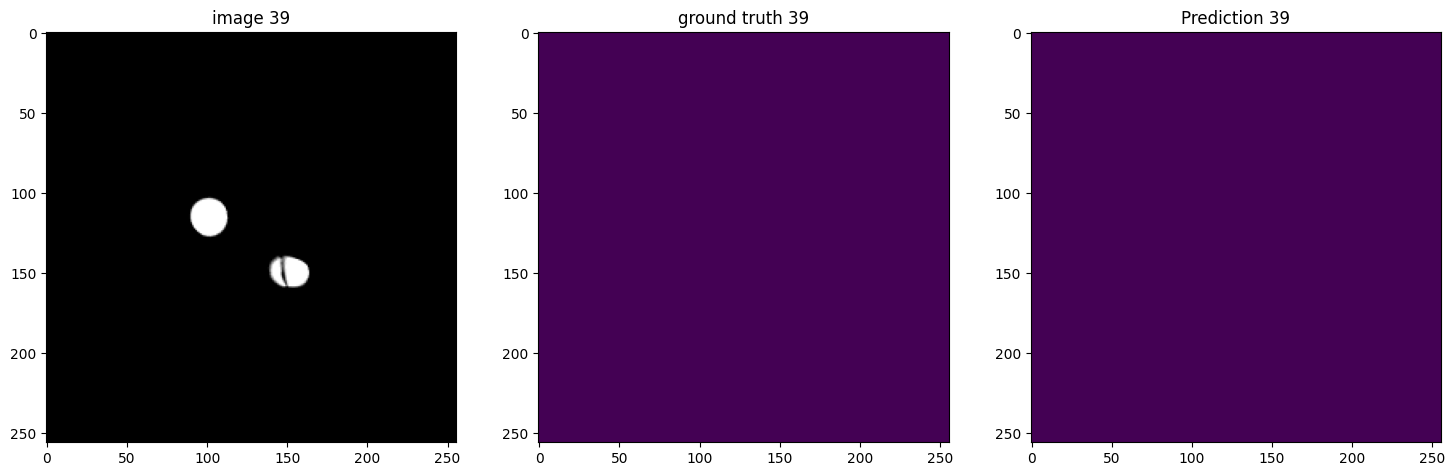

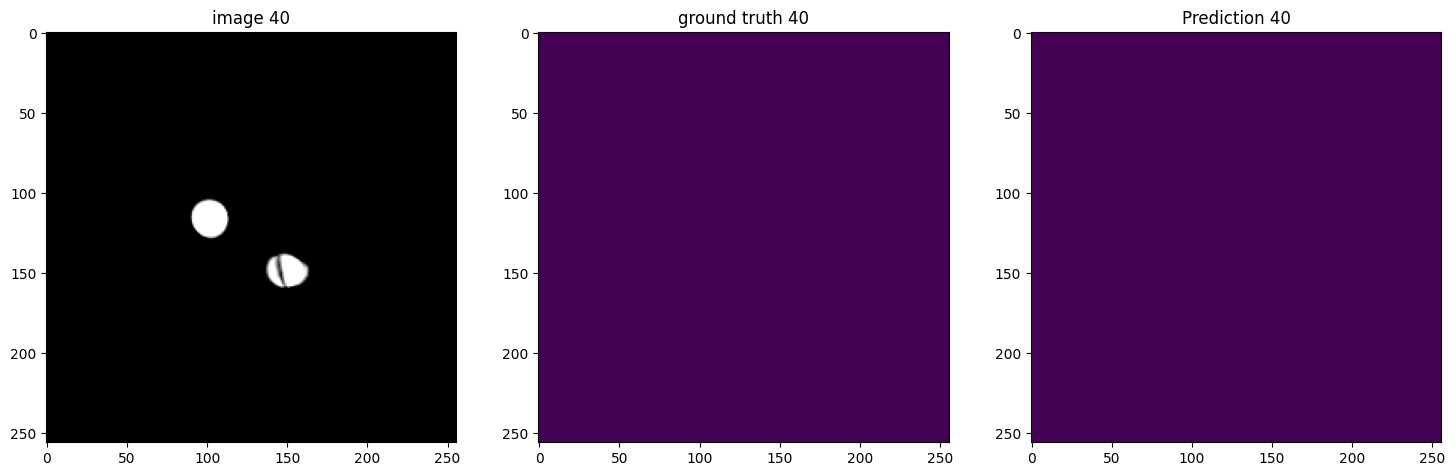

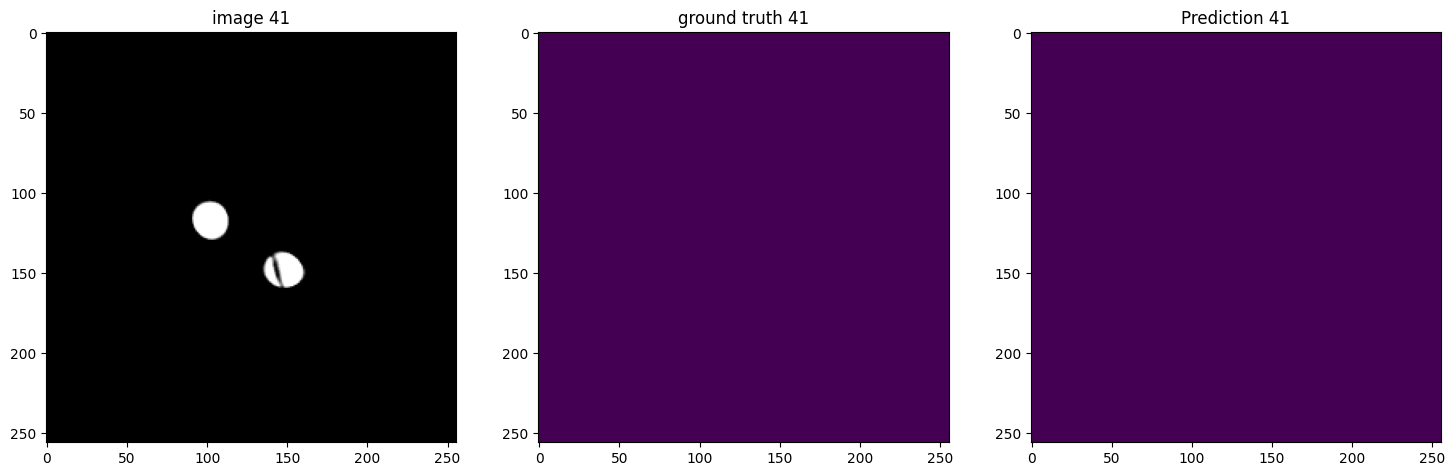

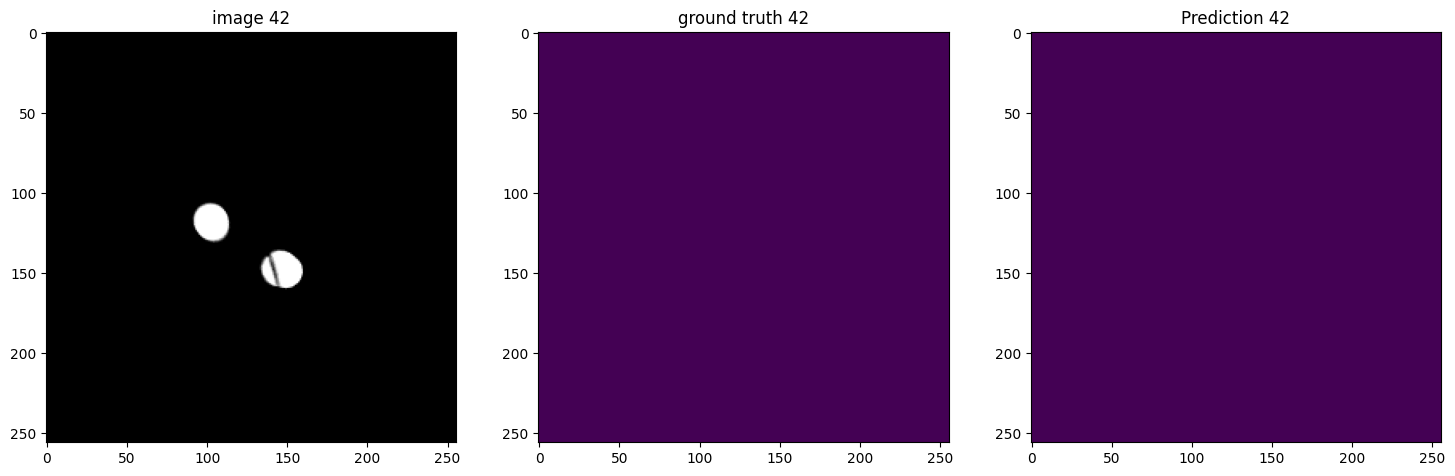

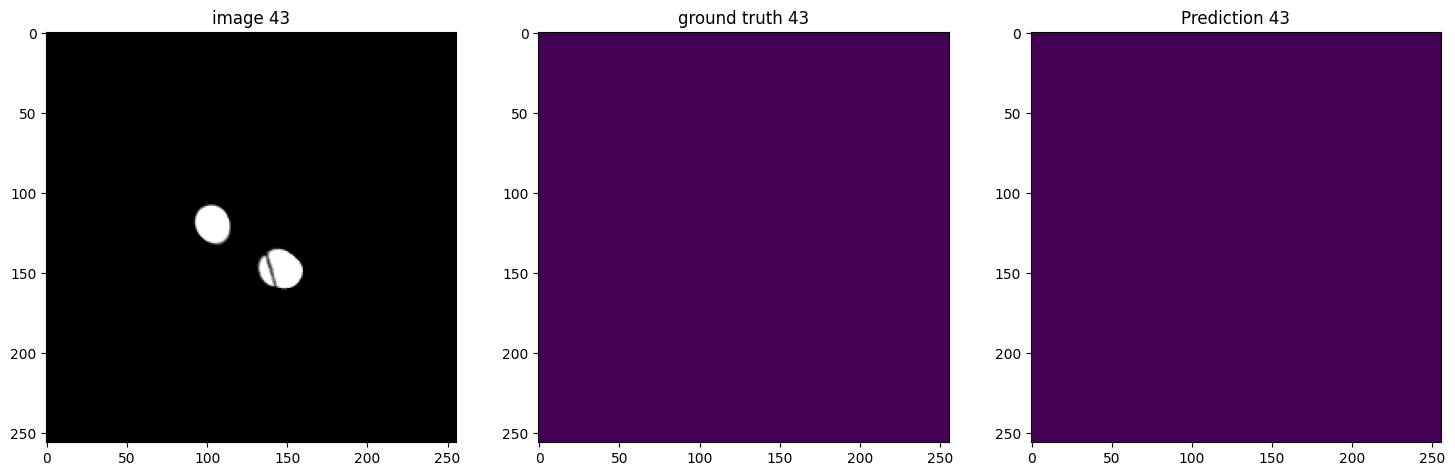

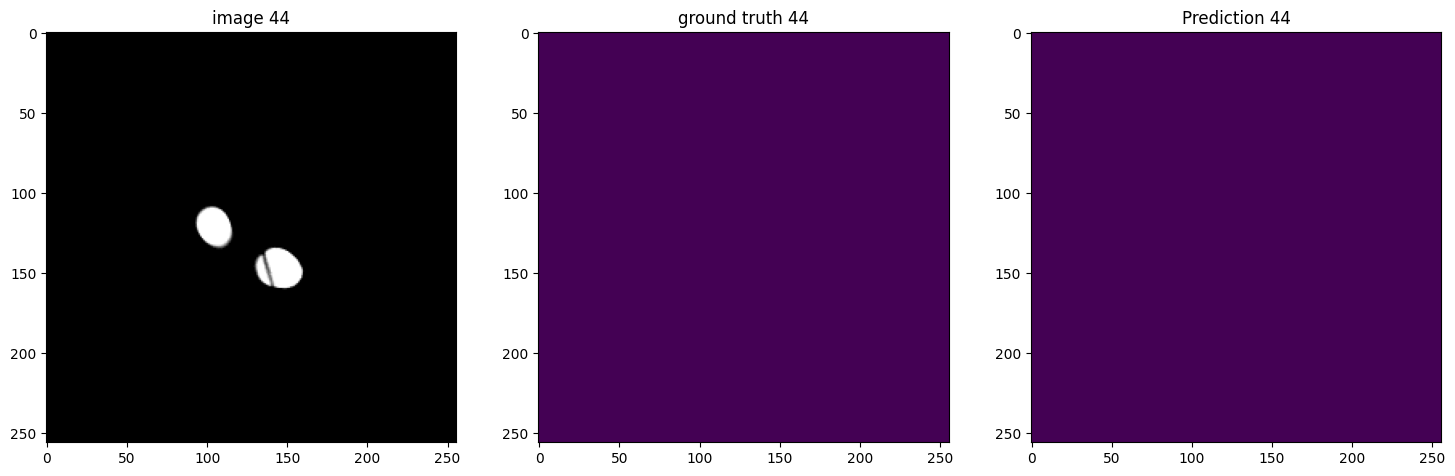

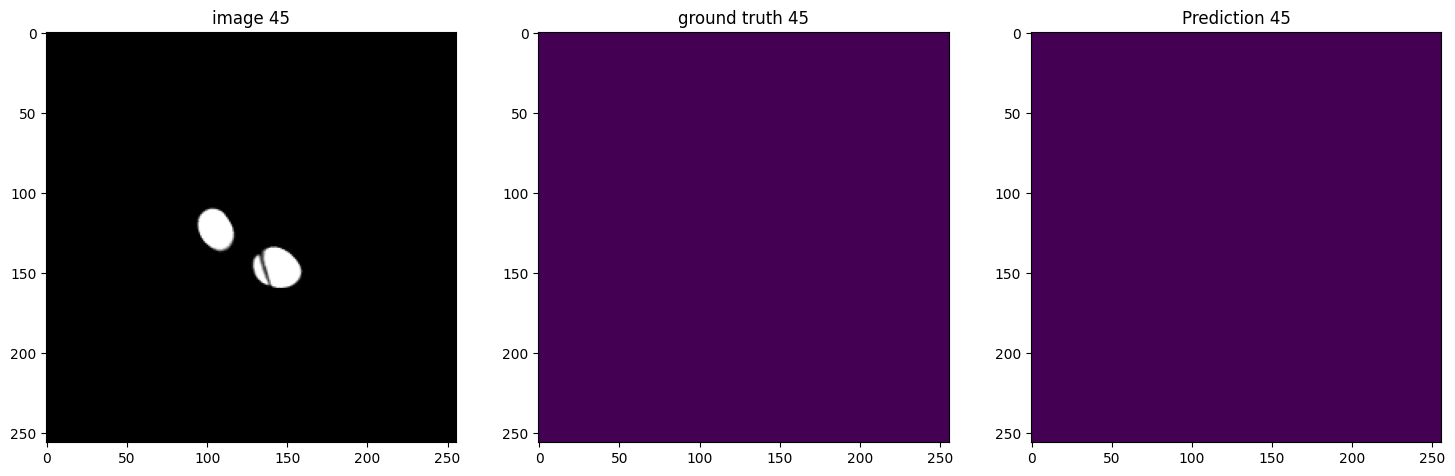

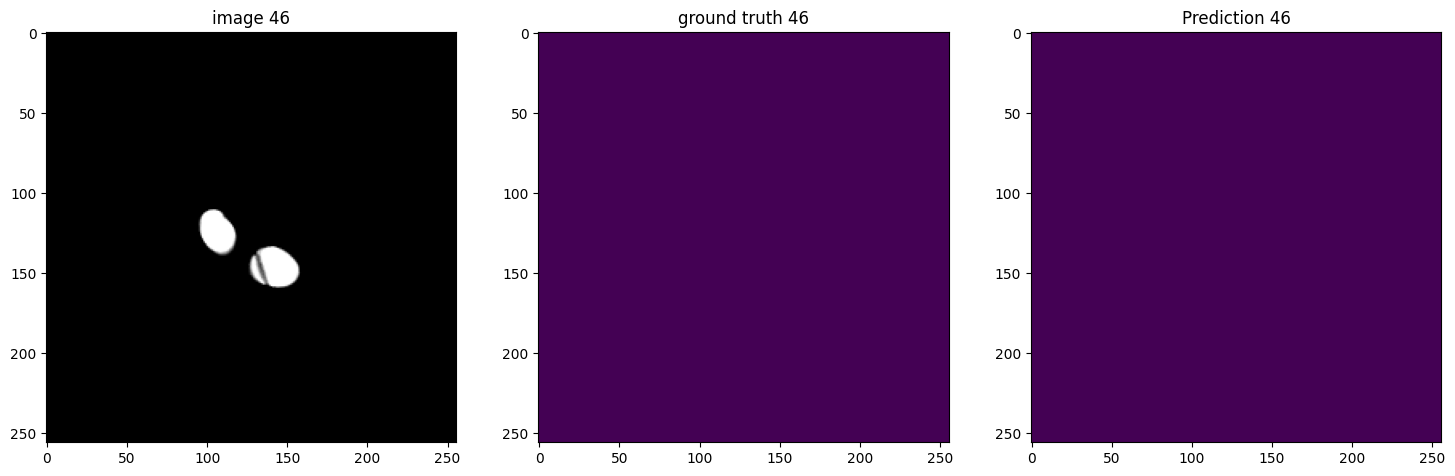

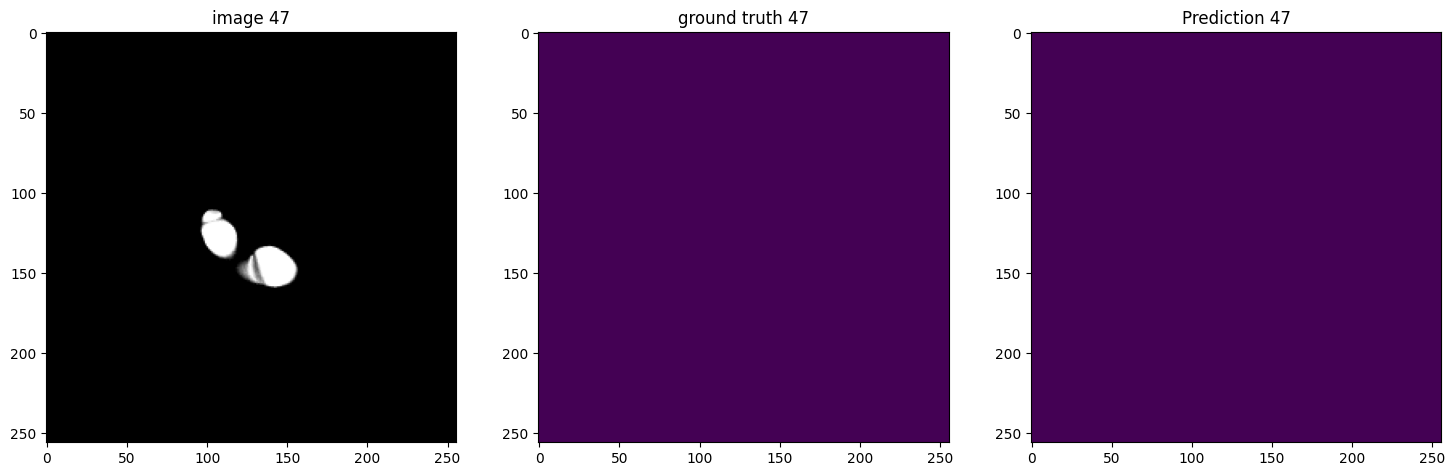

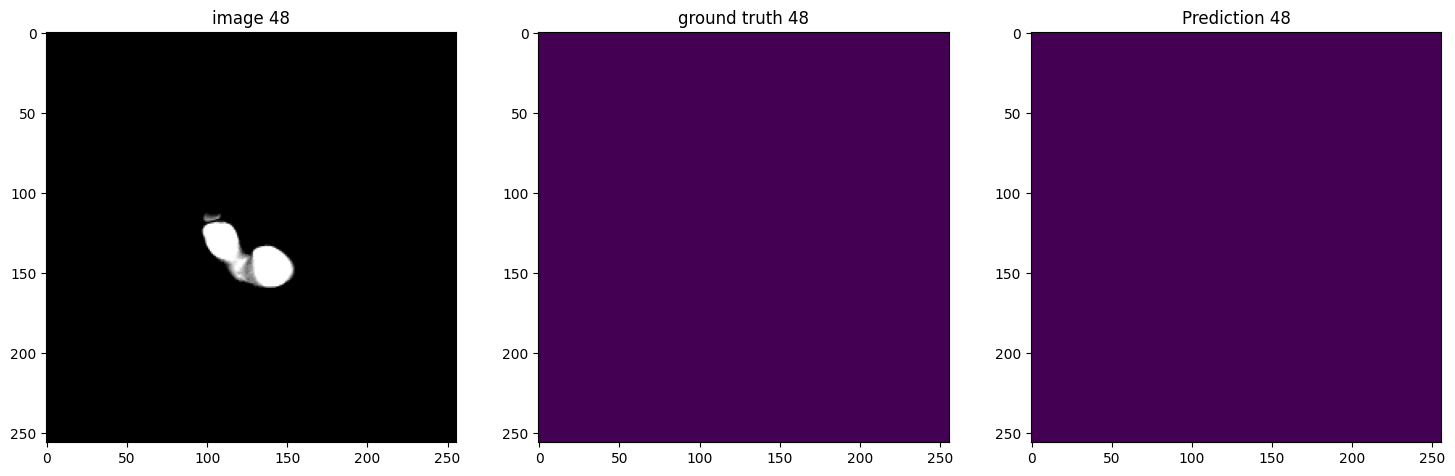

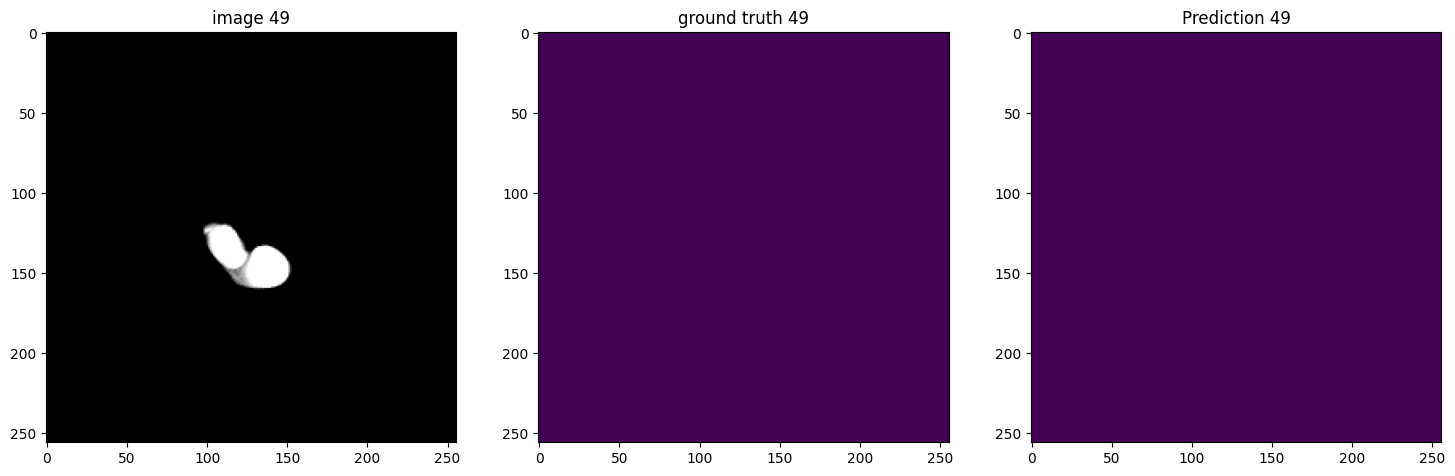

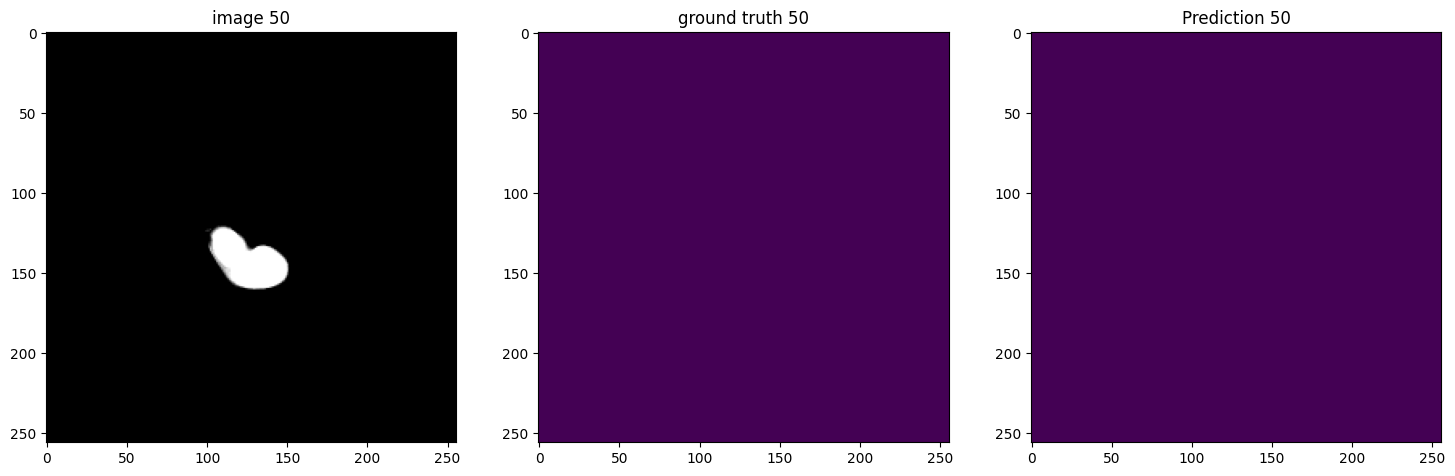

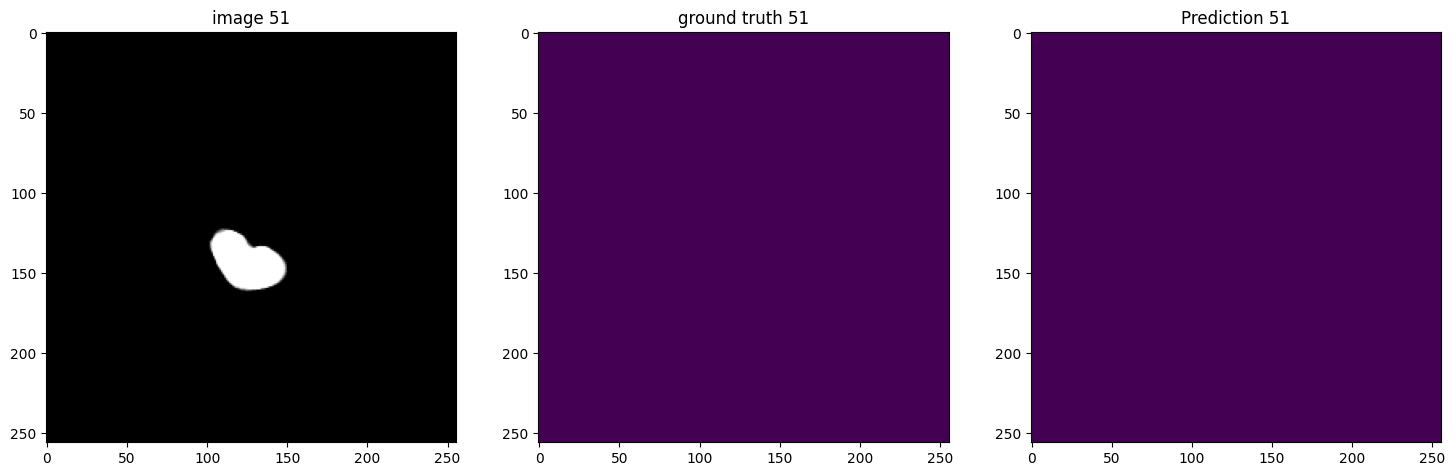

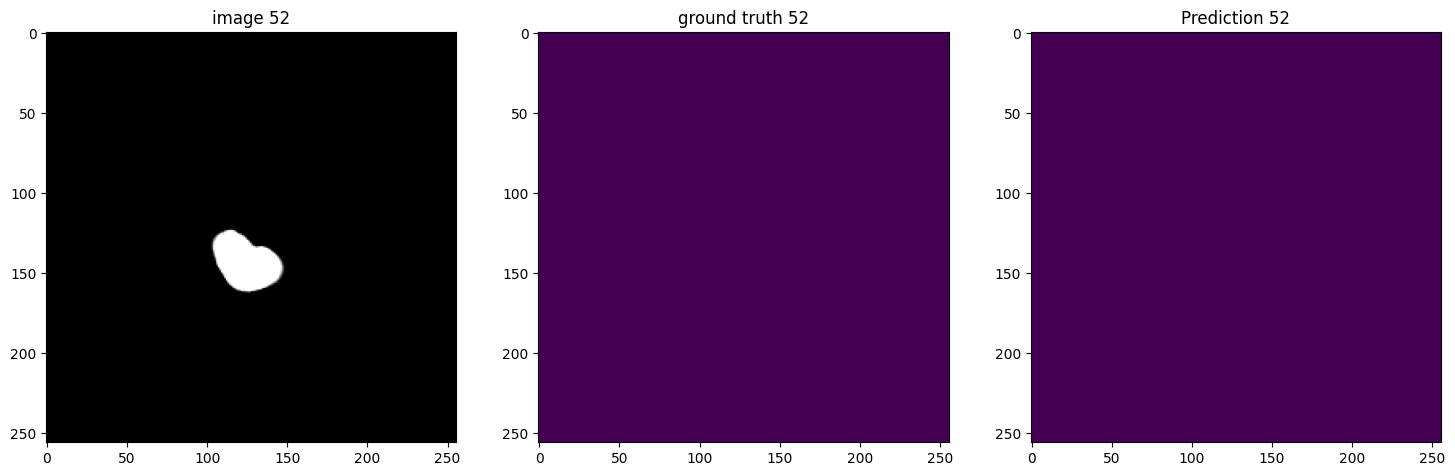

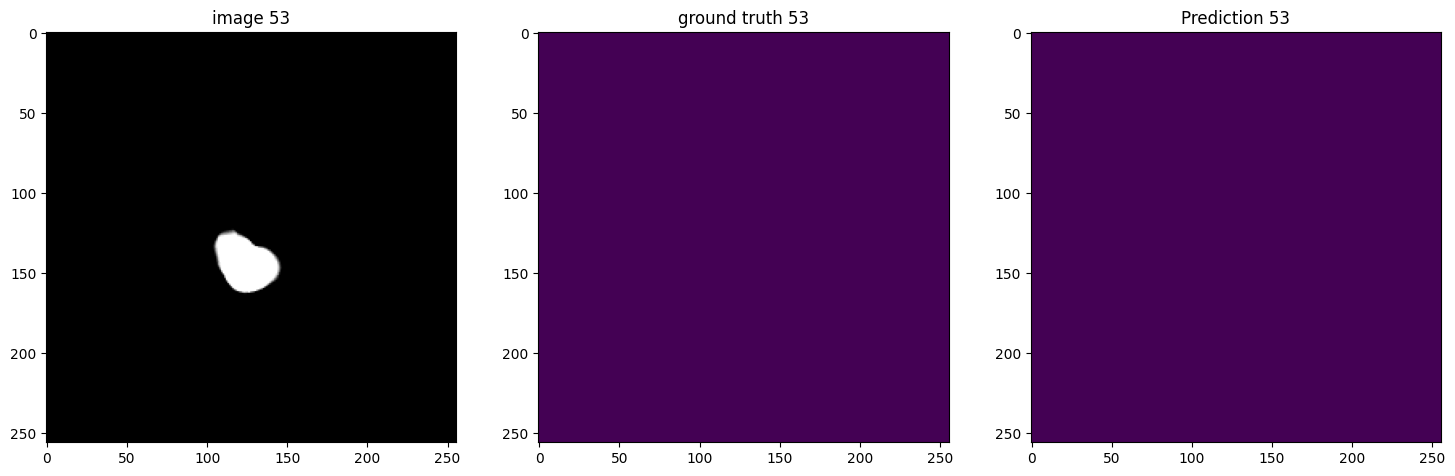

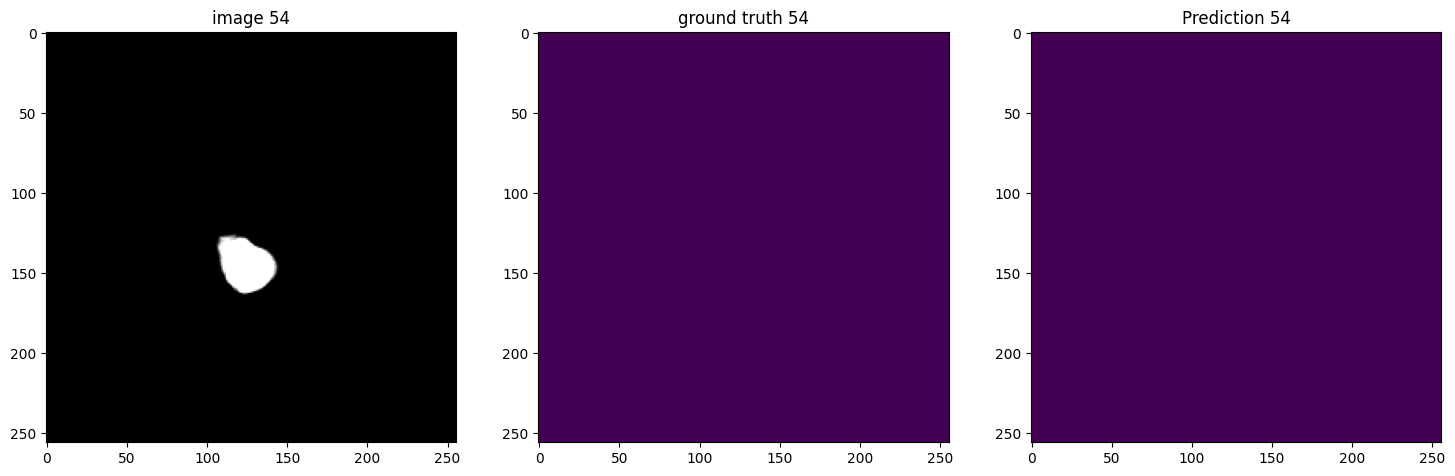

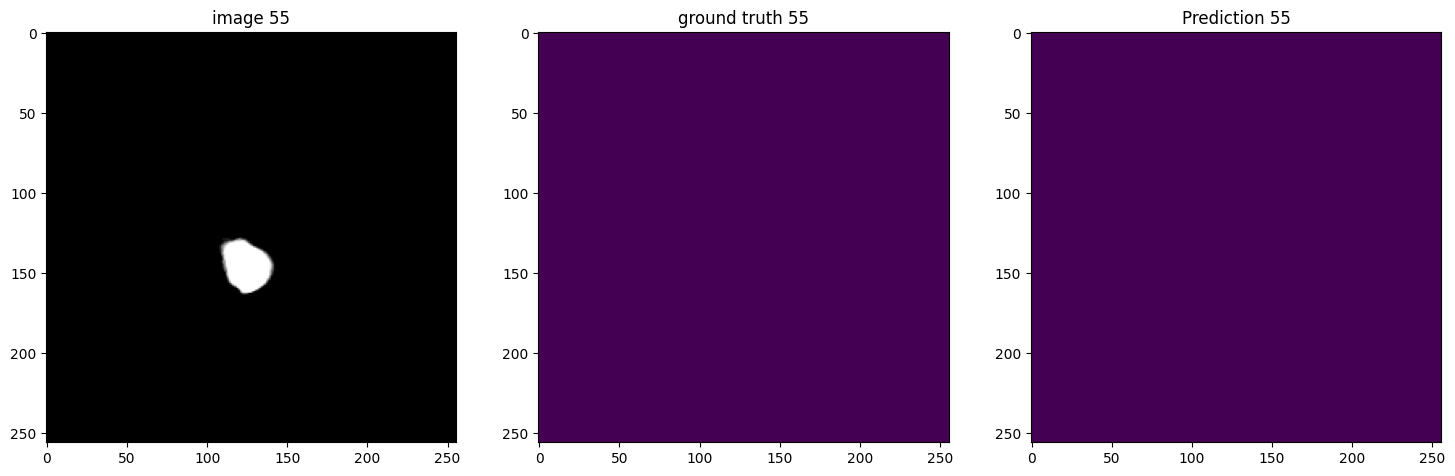

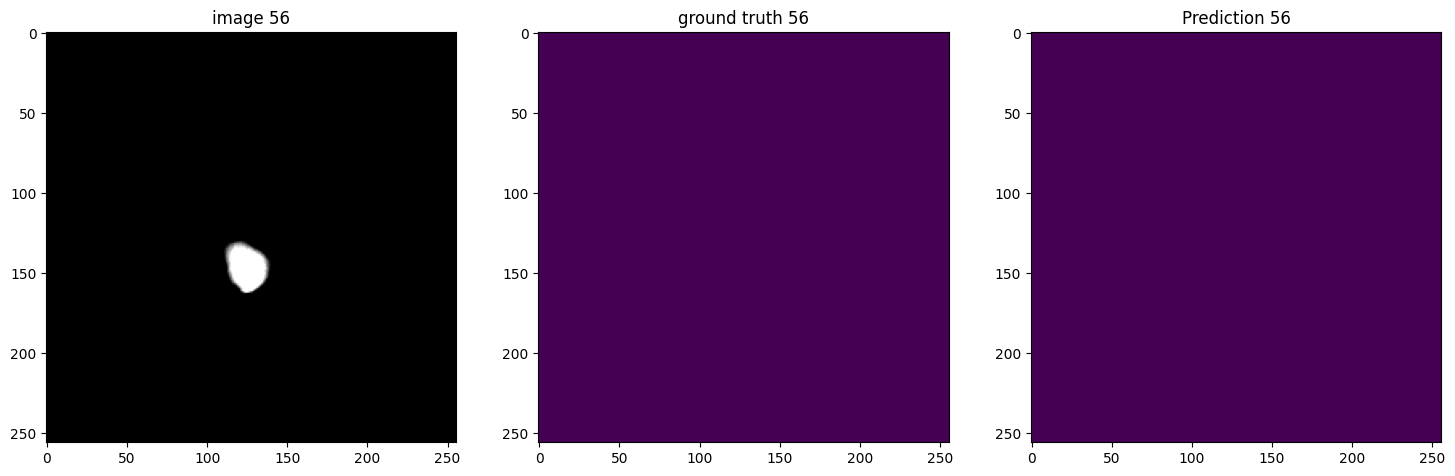

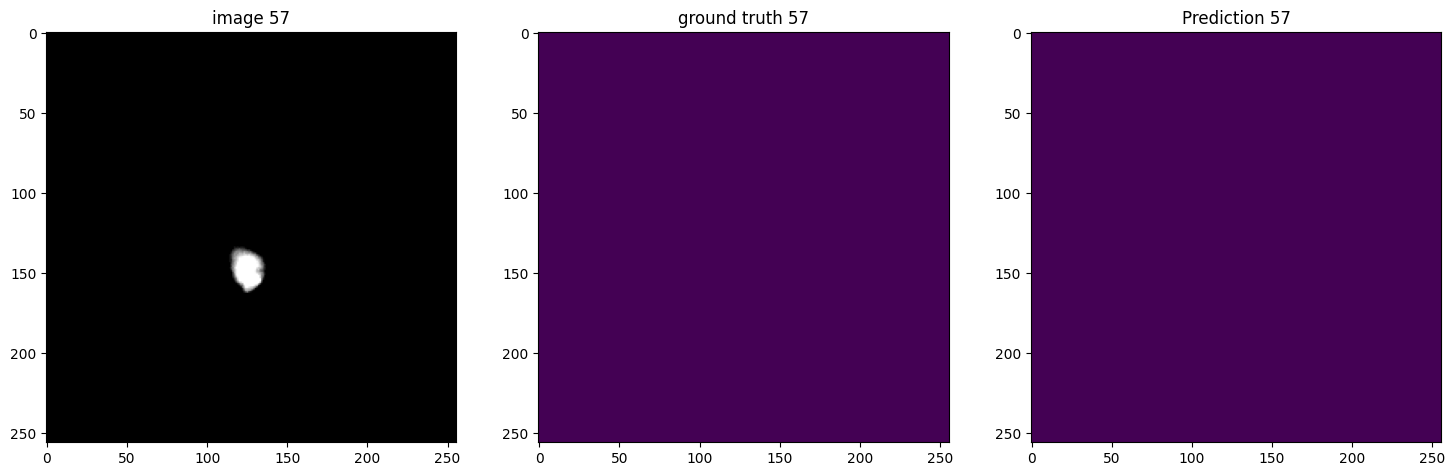

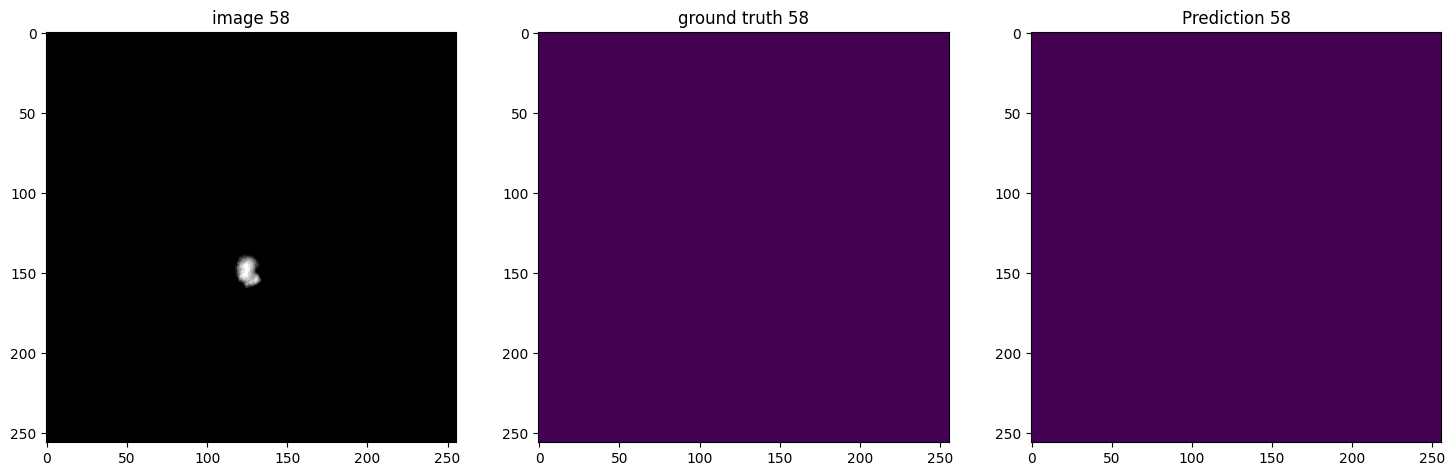

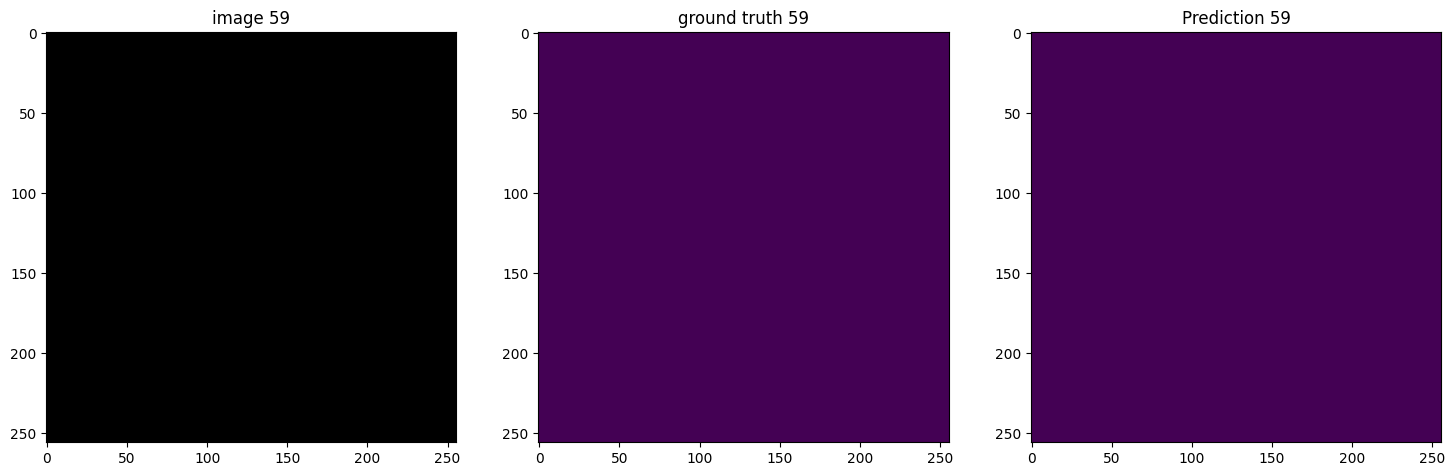

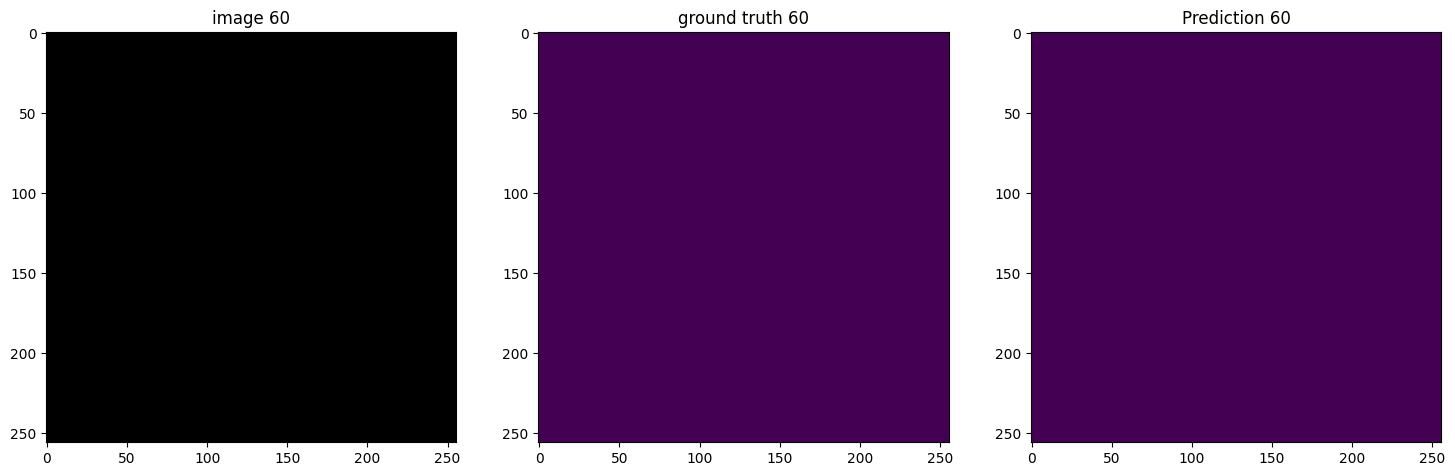

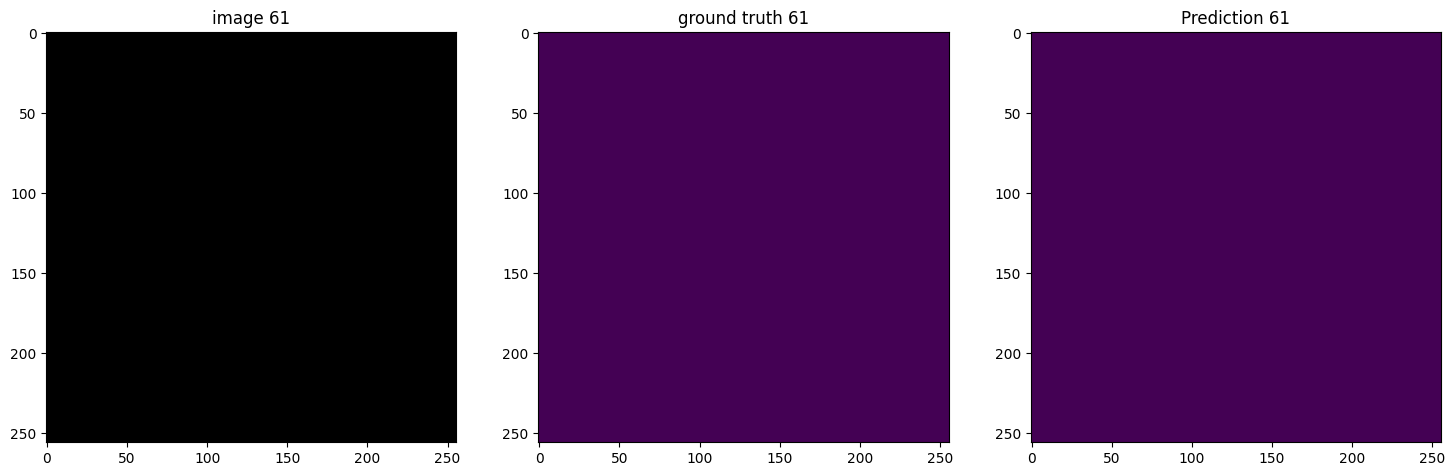

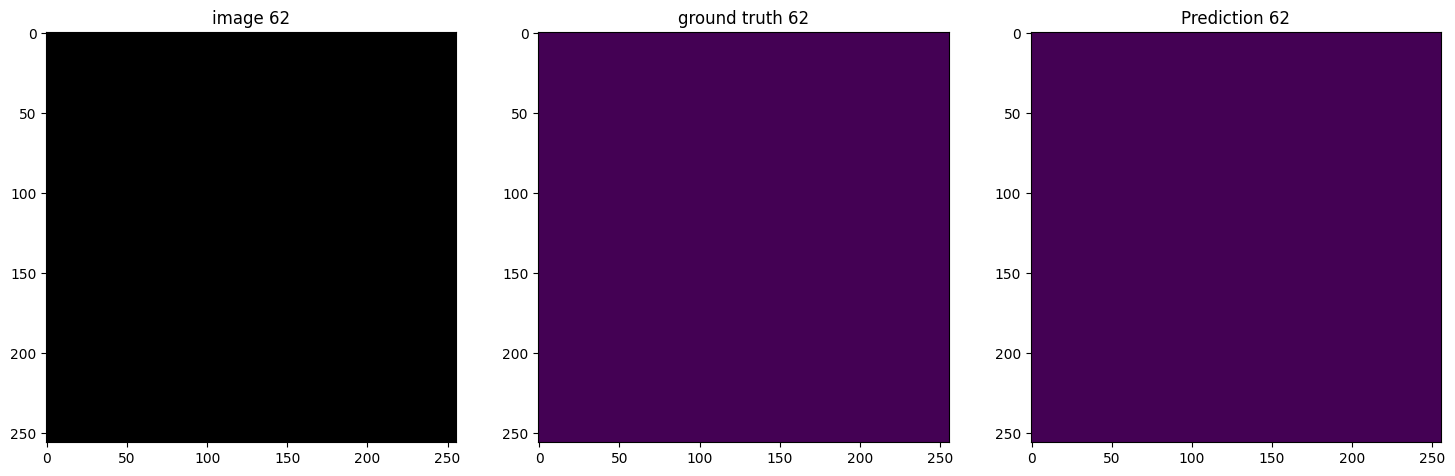

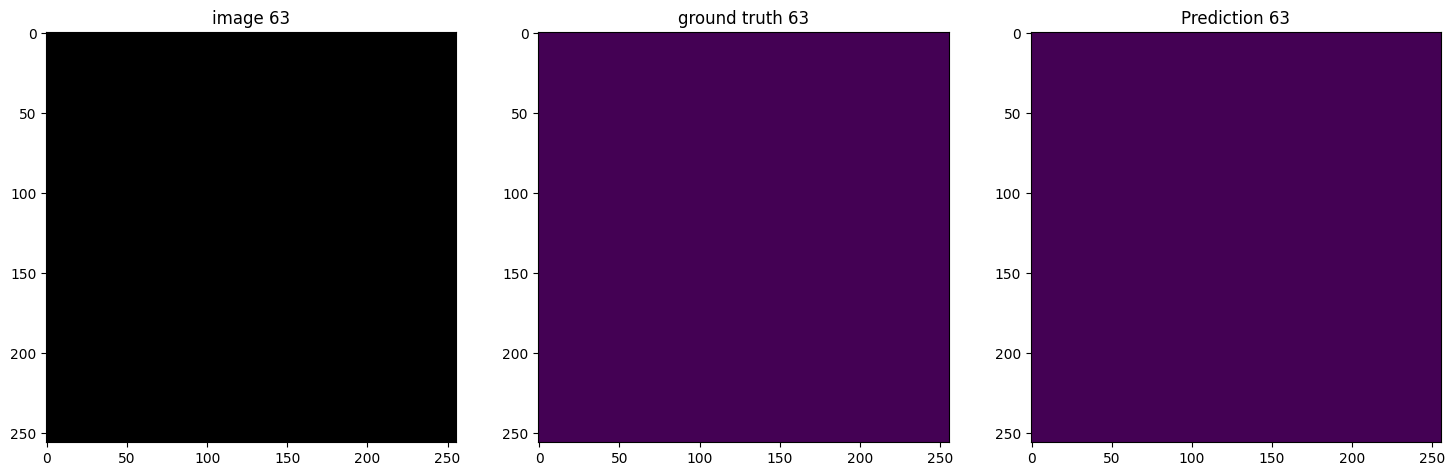

In [14]:
# # Define data directories
# data_dir = 'D:/grad/Landmarks-images'
# model_dir = Path("D:/grad/Landmarks-images/Landmark seg all points model")

# # Define test paths
# path_test_volumes = sorted(glob(os.path.join(data_dir, "TestVol", "*.nii.gz")))
# path_test_segmentation = sorted(glob(os.path.join(data_dir, "TestSeg", "*.nii.gz")))

# # Define transforms for test data
# test_transforms = Compose([
#     LoadImaged(keys=["vol", "seg"]),
#     AddChanneld(keys=["vol", "seg"]),
#     Spacingd(keys=["vol", "seg"], pixdim=(1.0, 1.0, 1.0), mode=("bilinear", "nearest")),
#     Orientationd(keys=["vol", "seg"], axcodes="RAS"),
#     ScaleIntensityRanged(keys=["vol"], a_min=0, a_max=300, clip=False),
#     Resized(keys=["vol", "seg"], spatial_size=[256, 256, 64]),
#     ToTensord(keys=["vol", "seg"]),
# ])
sw_batch_size = 4
roi_size = (256, 256, 64)
with torch.no_grad():
    test_patient = first(test_loader)
    t_volume = test_patient['vol']

    test_outputs = sliding_window_inference(t_volume.to(device), roi_size, sw_batch_size, model)
    sigmoid_activation = Activations(sigmoid=True)
    test_outputs = sigmoid_activation(test_outputs)
    test_outputs = test_outputs > 0.7
# adjust range according to third dimension of the roi_size
    for i in range(64):
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(test_patient["vol"][0, 0, :, :, i], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"ground truth {i}")
        plt.imshow(test_patient["seg"][0, 0, :, :, i] != 0)
        plt.subplot(1, 3, 3)
        plt.title(f"Prediction {i}")
        plt.imshow(test_patient["seg"][0, 0, :, :, i] != 0)
        ## Save image
        plt.savefig(f"{path}/{i}.png")
        plt.show()